# Ergodic EAS GMM Regression

**Objectives:**
 * Investigate impact of rupture-distance proportional aleatory variability

Secondary objectives:
 * Test source vs site dependence of rupture-distance proportional aleatory variability
 * Evaluate correlation between source constant and rupture distance scaled random effects 
 * Evaluate correlation between site constant and rupture distance scaled random effects 
 
To do list:
 * Evaluate corelation
 * Scale & Normalize residuals 
 * Think of seismological constraints on mag scl
 * Figure for impact of distant records
 * Maps of random terms (missing coordinates)
 
Other Notes:
 * Couldn’t match pseudo depth values

## Set Up

### Load Libraries

In [1]:
#standard libraries
library(assertthat)
library(stringr)
library(pracma)
library(plyr)
library(dplyr)
library(tidyverse)
#regression libraries
library(lme4)
#plotting libraries
library(ggplot2)
library(ggpubr)
library(RColorBrewer)
library(scales)
library(repr)
#user functions
source(file.path('..','..','r_lib','auxiliary_functions.r'))

options(warn=-1)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ readr     2.1.4
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::arrange()   masks plyr::arrange()
✖ purrr::compact()   masks plyr::compact()
✖ dplyr::count()     masks plyr::count()
✖ purrr::cross()     masks pracma::cross()
✖ dplyr::desc()      masks plyr::desc()
✖ dplyr::failwith()  masks plyr::failwith()
✖ dplyr::filter()    masks stats::filter()
✖ tibble::has_name() masks assertthat::has_name()
✖ dplyr::

### Plotting Setup

In [2]:
base_breaks <- function(n = 10){
  function(x) {
    axisTicks(log10(range(x, na.rm = TRUE)), log = TRUE, n = n)
  }
}
#log breaks
breaks_log       <- 10^(-10:10)
breaks_log_minor <- rep(1:9, 21)*(10^rep(-10:10, each=9))
#plotting theme
theme_set(theme_linedraw())

#text size
size_title <- 15
size_text  <- 12

#color palette
color_dW     <- "#666666"
color_dB     <- "#00BFC4"
color_dBP    <- "#4DAF4A"
color_dS2S   <- "#F781BF"
color_dSP2SP <- "#FFFF33"
color_dT     <- "#F8766D"

### Define Variables

In [3]:
#EAS flatfile (removed outliers 2023-11-10)
fname_flatfile <- file.path('..','..','..','Raw_files','flatfiles','fas_flatfile_v2no_outliers_20231130.csv')

#scaling factor for random effects distance scaling
scl_rrup_rref <- 0.01

#UTM Zome
utm_zone <- '11S'

### Load Data

In [4]:
#read flatifle
df_flatfile_eas <- read_csv(fname_flatfile, show_col_types = FALSE)
colnames(df_flatfile_eas)
head(df_flatfile_eas)

[1] "motion_id"        "event_id"         "station_id"       "path_id"         
 [5] "user_id"          "event_name"       "comcat_id"        "magnitude"       
 [9] "ztor"             "vs30"             "rrup"             "ln(R+H(M))"      
[13] "Rhypo"            "min useable Freq" "0.5 Hz"           "1 Hz"            
[17] "5 Hz"             "N pts"            "Min R"            "Max R"           
[21] "R Ratio"          "R range"

motion_id event_id station_id path_id user_id event_name  comcat_id magnitude
1 41        29       319        39      5       Lytle Creek ci3323898 5.33     
2 42        29        72        40      5       Lytle Creek ci3323898 5.33     
3 43        29        71        41      5       Lytle Creek ci3323898 5.33     
4 44        29        73        42      5       Lytle Creek ci3323898 5.33     
5 45        29       105        43      5       Lytle Creek ci3323898 5.33     
6 46        29       322        44      5       Lytle Creek ci3323898 5.33     
  ztor  vs30   ⋯ Rhypo  min useable Freq 0.5 Hz      1 Hz        5 Hz       
1 5.627 450.28 ⋯ 106.63 0.500            0.000423337 0.004293677 0.005908231
2 5.627 477.22 ⋯  23.89 0.500            0.002761784 0.003555263 0.004201327
3 5.627 813.50 ⋯  20.50 1.000            0.002556580 0.001322844 0.002992845
4 5.627 301.95 ⋯  32.48 0.500            0.001764019 0.003915060 0.004215072
5 5.627 680.87 ⋯  21.94 0.375            0.003347107 0.003074552 0.020774373
6 5.627 316.46 ⋯  76.65 0.375            0.001001172 0.002255955 0.003774867
  N pts Min R Max R  R Ratio  R range
1 10    12.14 103.39 8.516474 91.25  
2 10    12.14 103.39 8.516474 91.25  
3 10    12.14 103.39 8.516474 91.25  
4 10    12.14 103.39 8.516474 91.25  
5 10    12.14 103.39 8.516474 91.25  
6 10    12.14 103.39 8.516474 91.25

### Preprocessing (set up target value and scaling terms)

In [5]:
calc_scl_terms <- function(df_flt, mag='magnitude', rrup='rrup', vs30='vs30', resvar='f5Hz', scl_rrup_rref=1,
                           fun_mag_quad, fun_pseudo_depth){
    
    #rupture distance scaling
    df_flt[,'rrup']   <- df_flt[,rrup]
    #magnitude scaling
    df_flt[,'mag']    <- df_flt[,mag]
    #quadratic magnitude scaling
    df_flt[,'mag2']   <- fun_mag_quad(df_flt[,mag]) 
    #pseudo depth
    df_flt[,'pdepth'] <-  fun_pseudo_depth(df_flt$mag)
    #geometrical spreading
    df_flt[,'gs']     <-  log(df_flt$rrup + df_flt$pdepth)
    #site scaling
    df_flt[,'vs30']   <- df_flt[,vs30]
    df_flt[,'lnvs30'] <- log(df_flt[,vs30])
    
    #distance scaling for random effects
    df_flt['reff_rrup'] <- scl_rrup_rref * df_flt['rrup']
    
    #respones variable 
    df_flt['y'] <- log(df_flatfile_eas[resvar])
    
    return(df_flt)
}

#add utm coordinates

#custom scaling functions
fun_mag_quad     <- function(mag) (8.5-mag)^2 
fun_pseudo_depth <- function(mag)  5 * exp(0.4*(mag-6))

#compute scaling terms
df_flatfile_eas <- calc_scl_terms(df_flatfile_eas, resvar='5 Hz', scl_rrup_rref=scl_rrup_rref, fun_mag_quad=fun_mag_quad, fun_pseudo_depth=fun_pseudo_depth)

## Regression 

#### Regression Formulas

In [6]:
# Fixed Effects Ergodic Models
# ---   ---   ---   ---   ---
#base model
frm_gmm_erg_fxd             <- 'y ~ 1 + mag + mag2 + gs + rrup + lnvs30'

# Mixed Effects Ergodic Models
# ---   ---   ---   ---   ---
#random event constant,
#aleat: deltaB_e + deltaW_es
frm_gmm_erg_rnd_ceq         <- 'y ~ 1 + mag + mag2 + gs + rrup + lnvs30 + (1            |event_id)'

#random event constant and distance term, 
#aleat: deltaB_e + Rrup * deltaBP_e + deltaW_es
frm_gmm_erg_rnd_ceq_req     <- 'y ~ 1 + mag + mag2 + gs + rrup + lnvs30 + (1 + reff_rrup|event_id)'

#random event constant and site distance term, 
#aleat: deltaB_e + Rrup * deltaBP_s + deltaW_es
frm_gmm_erg_rnd_ceq_rst     <- 'y ~ 1 + mag + mag2 + gs + rrup + lnvs30 + (1            |event_id) + (0 + reff_rrup|station_id)'


# Mixed Effects Single Station Models
# ---   ---   ---   ---   ---
#random event constant,
#aleat: deltaB_e + deltaS2S_s + deltaW_es
frm_gmm_ss_rnd_ceq_cst      <- 'y ~ 1 + mag + mag2 + gs + rrup + lnvs30 + (1            |event_id) + (1            |station_id)'

#random event constant and source distance term, 
#aleat: deltaB_e + deltaBP_e + deltaS2S_e + deltaW_es
frm_gmm_ss_rnd_ceq_cst_req  <- 'y ~ 1 + mag + mag2 + gs + rrup + lnvs30 + (1 + reff_rrup|event_id) + (1            |station_id)'

#random event constant and site distance term, 
#aleat: deltaB_e + deltaBP_s + deltaS2S_s + deltaW_es
frm_gmm_ss_rnd_ceq_cst_rst  <- 'y ~ 1 + mag + mag2 + gs + rrup + lnvs30 + (1            |event_id) + (1 + reff_rrup|station_id)'

### Initialize Data Frames

In [7]:
df_gmm_coeffs  <- data.frame()
df_gmm_res     <- df_flatfile_eas[,c('motion_id','event_id','station_id','path_id','event_name','comcat_id','magnitude','ztor','vs30','rrup')]
df_gmm_reff_eq <- data.frame(event_id=unique(df_flatfile_eas$event_id))     #event random effects
df_gmm_reff_eq <- df_gmm_reff_eq %>% left_join(df_flatfile_eas[,c('event_id','event_name','comcat_id','magnitude')], by='event_id', multiple='first')
df_gmm_reff_st <- data.frame(station_id=unique(df_flatfile_eas$station_id)) #station random effects
df_gmm_reff_st <- df_gmm_reff_st %>% left_join(df_flatfile_eas[,c('station_id','vs30')], by='station_id', multiple='first')

### Ergodic Model: Fixed Effects

In [8]:
#run regression
fit_gmm_erg_fxd <- lm(frm_gmm_erg_fxd, data=df_flatfile_eas)

#summarize coefficients
df_gmm_coeffs <- bind_rows(df_gmm_coeffs, as.data.frame(t(coef(fit_gmm_erg_fxd)), row.names='gmm_erg_fxd'))
df_gmm_coeffs['gmm_erg_fxd','phi'] <- sigma(fit_gmm_erg_fxd)

df_gmm_res[,'gmm_erg_fxd_dT'] <- residuals(fit_gmm_erg_fxd)

#regression summary
summary(fit_gmm_erg_fxd)


Call:
lm(formula = frm_gmm_erg_fxd, data = df_flatfile_eas)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.1829 -0.6054  0.0656  0.6881  3.9225 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.316369   0.300148  -1.054    0.292    
mag          0.774897   0.037407  20.715   <2e-16 ***
mag2        -0.123094   0.005926 -20.770   <2e-16 ***
gs          -1.073847   0.022118 -48.550   <2e-16 ***
rrup        -0.008684   0.000205 -42.357   <2e-16 ***
lnvs30      -0.665908   0.019215 -34.655   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.063 on 22669 degrees of freedom
Multiple R-squared:  0.8211,	Adjusted R-squared:  0.821 
F-statistic: 2.08e+04 on 5 and 22669 DF,  p-value: < 2.2e-16


### Ergodic Model: Random Event Constant

In [9]:
#run regression
fit_gmm_erg_rnd_ceq <- lmer(frm_gmm_erg_rnd_ceq, df_flatfile_eas)

#summarize coefficients
df_gmm_coeffs  <- bind_rows(df_gmm_coeffs, as.data.frame(t(fixef(fit_gmm_erg_rnd_ceq)), row.names='gmm_erg_rnd_ceq'))
df_gmm_coeffs['gmm_erg_rnd_ceq','phi'] <- sigma(fit_gmm_erg_rnd_ceq)
df_gmm_coeffs['gmm_erg_rnd_ceq','tau'] <- sqrt(VarCorr(fit_gmm_erg_rnd_ceq)$event_id[1,1])

df_gmm_res[,'gmm_erg_rnd_ceq_dW'] <- residuals(fit_gmm_erg_rnd_ceq)

df_gmm_reff_eq <- merge(df_gmm_reff_eq, ranef(fit_gmm_erg_rnd_ceq)$event_id['(Intercept)'], by.x='event_id', by.y=0) %>% 
                    rename('gmm_erg_rnd_ceq_dB' = '(Intercept)')

#regression summary
summary(fit_gmm_erg_rnd_ceq)

Linear mixed model fit by REML ['lmerMod']
Formula: y ~ 1 + mag + mag2 + gs + rrup + lnvs30 + (1 | event_id)
   Data: df_flatfile_eas

REML criterion at convergence: 57522.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.3413 -0.6164  0.0104  0.6304  4.4233 

Random effects:
 Groups   Name        Variance Std.Dev.
 event_id (Intercept) 0.4394   0.6629  
 Residual             0.7103   0.8428  
Number of obs: 22675, groups:  event_id, 240

Fixed effects:
              Estimate Std. Error t value
(Intercept) -2.8999674  1.6668084  -1.740
mag          1.0173477  0.2359952   4.311
mag2        -0.0845864  0.0353128  -2.395
gs          -0.9784649  0.0190648 -51.323
rrup        -0.0095845  0.0001812 -52.906
lnvs30      -0.5814963  0.0154503 -37.637

Correlation of Fixed Effects:
       (Intr) mag    mag2   gs     rrup  
mag    -0.995                            
mag2   -0.991  0.984                     
gs     -0.042  0.003  0.002              
rrup    0.028  0.006  0.008 -0.89

### Ergodic Model: Random Event Constant + Random Event Distance Term

In [10]:
#run regression
fit_gmm_erg_rnd_ceq_req <- lmer(frm_gmm_erg_rnd_ceq_req, df_flatfile_eas)

#summarize coefficients
df_gmm_coeffs  <- bind_rows(df_gmm_coeffs, as.data.frame(t(fixef(fit_gmm_erg_rnd_ceq)), row.names='gmm_erg_rnd_ceq_req'))
df_gmm_coeffs['gmm_erg_rnd_ceq_req','phi']  <- sigma(fit_gmm_erg_rnd_ceq_req)
df_gmm_coeffs['gmm_erg_rnd_ceq_req','tau']  <- sqrt(VarCorr(fit_gmm_erg_rnd_ceq_req)$event_id[1,1])
df_gmm_coeffs['gmm_erg_rnd_ceq_req','tauP'] <- sqrt(VarCorr(fit_gmm_erg_rnd_ceq_req)$event_id[2,2]) * scl_rrup_rref

df_gmm_res[,'gmm_erg_rnd_ceq_req_dW'] <- residuals(fit_gmm_erg_rnd_ceq_req)

df_gmm_reff_eq <- merge(df_gmm_reff_eq, ranef(fit_gmm_erg_rnd_ceq_req)$event_id['(Intercept)'], by.x='event_id', by.y=0) %>% 
                    rename('gmm_erg_rnd_ceq_req_dB' = '(Intercept)')
df_gmm_reff_eq <- merge(df_gmm_reff_eq, scl_rrup_rref * ranef(fit_gmm_erg_rnd_ceq_req)$event_id['reff_rrup'],   by.x='event_id', by.y=0) %>% 
                    rename('gmm_erg_rnd_ceq_req_dBP' = 'reff_rrup')

#regression summary
summary(fit_gmm_erg_rnd_ceq_req)

Linear mixed model fit by REML ['lmerMod']
Formula: y ~ 1 + mag + mag2 + gs + rrup + lnvs30 + (1 + reff_rrup | event_id)
   Data: df_flatfile_eas

REML criterion at convergence: 56307.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.4927 -0.6126  0.0095  0.6282  4.5705 

Random effects:
 Groups   Name        Variance Std.Dev. Corr
 event_id (Intercept) 0.2310   0.4806       
          reff_rrup   0.1329   0.3646   0.14
 Residual             0.6633   0.8145       
Number of obs: 22675, groups:  event_id, 240

Fixed effects:
              Estimate Std. Error t value
(Intercept)  2.0520525  1.3130754   1.563
mag          0.2934603  0.1850642   1.586
mag2        -0.1823096  0.0277578  -6.568
gs          -0.9915100  0.0209180 -47.400
rrup        -0.0089241  0.0003429 -26.028
lnvs30      -0.5840435  0.0151391 -38.578

Correlation of Fixed Effects:
       (Intr) mag    mag2   gs     rrup  
mag    -0.994                            
mag2   -0.990  0.984                     
gs 

### Ergodic Model: Random Event Constant + Random Station Distance Term

In [11]:
#run regression
fit_gmm_erg_rnd_ceq_rst <- lmer(frm_gmm_erg_rnd_ceq_rst, df_flatfile_eas)

#summarize coefficients
df_gmm_coeffs  <- bind_rows(df_gmm_coeffs, as.data.frame(t(fixef(fit_gmm_erg_rnd_ceq_rst)), row.names='gmm_erg_rnd_ceq_rst'))
df_gmm_coeffs['gmm_erg_rnd_ceq_rst','phi']      <- sigma(fit_gmm_erg_rnd_ceq_rst)
df_gmm_coeffs['gmm_erg_rnd_ceq_rst','tau']      <- sqrt(VarCorr(fit_gmm_erg_rnd_ceq_rst)$event_id[1,1])
df_gmm_coeffs['gmm_erg_rnd_ceq_rst','phiSP2SP'] <- sqrt(VarCorr(fit_gmm_erg_rnd_ceq_rst)$station_id[1,1]) * scl_rrup_rref

df_gmm_res[,'gmm_erg_rnd_ceq_rst_dW'] <- residuals(fit_gmm_erg_rnd_ceq_rst)

df_gmm_reff_eq <- merge(df_gmm_reff_eq, ranef(fit_gmm_erg_rnd_ceq_rst)$event_id['(Intercept)'], by.x='event_id', by.y=0) %>% 
                    rename('gmm_erg_rnd_ceq_rst_dB' = '(Intercept)')
df_gmm_reff_st <- merge(df_gmm_reff_st, scl_rrup_rref * ranef(fit_gmm_erg_rnd_ceq_rst)$station_id['reff_rrup'], by.x='station_id', by.y=0) %>% 
                    rename('gmm_erg_rnd_ceq_rst_dSP2SP' = 'reff_rrup')

#regression summary
summary(fit_gmm_erg_rnd_ceq_rst)

Linear mixed model fit by REML ['lmerMod']
Formula: y ~ 1 + mag + mag2 + gs + rrup + lnvs30 + (1 | event_id) + (0 +  
    reff_rrup | station_id)
   Data: df_flatfile_eas

REML criterion at convergence: 49435

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.3284 -0.5606 -0.0001  0.5686  5.9959 

Random effects:
 Groups     Name        Variance Std.Dev.
 station_id reff_rrup   0.1240   0.3521  
 event_id   (Intercept) 0.3421   0.5849  
 Residual               0.4120   0.6418  
Number of obs: 22675, groups:  station_id, 4414; event_id, 240

Fixed effects:
              Estimate Std. Error t value
(Intercept) -1.3875568  1.4718196  -0.943
mag          0.7453535  0.2082043   3.580
mag2        -0.1206238  0.0311235  -3.876
gs          -1.0451210  0.0157586 -66.321
rrup        -0.0082764  0.0001884 -43.937
lnvs30      -0.4948379  0.0186457 -26.539

Correlation of Fixed Effects:
       (Intr) mag    mag2   gs     rrup  
mag    -0.994                            
mag2   -0.990  0

### Single Station Model: Random Event Constant + Random Station Constant

In [12]:
#run regression
fit_gmm_ss_rnd_ceq_cst <- lmer(frm_gmm_ss_rnd_ceq_cst, df_flatfile_eas)

#summarize coefficients
df_gmm_coeffs  <- bind_rows(df_gmm_coeffs, as.data.frame(t(fixef(fit_gmm_ss_rnd_ceq_cst)), row.names='gmm_ss_rnd_ceq_cst'))
df_gmm_coeffs['gmm_ss_rnd_ceq_cst','phi']    <- sigma(fit_gmm_ss_rnd_ceq_cst)
df_gmm_coeffs['gmm_ss_rnd_ceq_cst','tau']    <- sqrt(VarCorr(fit_gmm_ss_rnd_ceq_cst)$event_id[1,1])
df_gmm_coeffs['gmm_ss_rnd_ceq_cst','phiS2S'] <- sqrt(VarCorr(fit_gmm_ss_rnd_ceq_cst)$station_id[1,1])

df_gmm_res[,'gmm_ss_rnd_ceq_cst_dW'] <- residuals(fit_gmm_ss_rnd_ceq_cst)

df_gmm_reff_eq <- merge(df_gmm_reff_eq, ranef(fit_gmm_ss_rnd_ceq_cst)$event_id['(Intercept)'],   by.x='event_id', by.y=0) %>% 
                    rename('gmm_ss_rnd_ceq_cst_dB' = '(Intercept)')
df_gmm_reff_st <- merge(df_gmm_reff_st, ranef(fit_gmm_ss_rnd_ceq_cst)$station_id['(Intercept)'], by.x='station_id', by.y=0) %>% 
                    rename('gmm_ss_rnd_ceq_cst_dS2S' ='(Intercept)')

#regression summary
summary(fit_gmm_ss_rnd_ceq_cst)

Linear mixed model fit by REML ['lmerMod']
Formula: y ~ 1 + mag + mag2 + gs + rrup + lnvs30 + (1 | event_id) + (1 |  
    station_id)
   Data: df_flatfile_eas

REML criterion at convergence: 46107.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-6.0998 -0.5680 -0.0192  0.5520  7.6493 

Random effects:
 Groups     Name        Variance Std.Dev.
 station_id (Intercept) 0.3537   0.5947  
 event_id   (Intercept) 0.3949   0.6284  
 Residual               0.3276   0.5724  
Number of obs: 22675, groups:  station_id, 4414; event_id, 240

Fixed effects:
              Estimate Std. Error t value
(Intercept) -2.4029039  1.5828458  -1.518
mag          0.8760767  0.2231113   3.927
mag2        -0.1050065  0.0333449  -3.149
gs          -1.0178317  0.0150366 -67.690
rrup        -0.0092130  0.0001423 -64.752
lnvs30      -0.4723717  0.0281869 -16.759

Correlation of Fixed Effects:
       (Intr) mag    mag2   gs     rrup  
mag    -0.991                            
mag2   -0.987  0.983      

### Single Station Model: Random Event Constant + Random Station Constant + Random Event Distance Term

In [13]:
#run regression
fit_gmm_ss_rnd_ceq_cst_req <- lmer(frm_gmm_ss_rnd_ceq_cst_req, df_flatfile_eas)

#summarize coefficients
df_gmm_coeffs  <- bind_rows(df_gmm_coeffs, as.data.frame(t(fixef(fit_gmm_ss_rnd_ceq_cst_req)), row.names='gmm_ss_rnd_ceq_cst_req'))
df_gmm_coeffs['gmm_ss_rnd_ceq_cst_req','phi']    <- sigma(fit_gmm_ss_rnd_ceq_cst_req)
df_gmm_coeffs['gmm_ss_rnd_ceq_cst_req','tau']    <- sqrt(VarCorr(fit_gmm_ss_rnd_ceq_cst_req)$event_id[1,1])
df_gmm_coeffs['gmm_ss_rnd_ceq_cst_req','tauP']   <- sqrt(VarCorr(fit_gmm_ss_rnd_ceq_cst_req)$event_id[2,2]) * scl_rrup_rref
df_gmm_coeffs['gmm_ss_rnd_ceq_cst_req','phiS2S'] <- sqrt(VarCorr(fit_gmm_ss_rnd_ceq_cst_req)$station_id[1,1])

df_gmm_res[,'gmm_ss_rnd_ceq_cst_req_dW'] <- residuals(fit_gmm_ss_rnd_ceq_cst_req)

df_gmm_reff_eq <- merge(df_gmm_reff_eq,                 ranef(fit_gmm_ss_rnd_ceq_cst_req)$event_id['(Intercept)'],   by.x='event_id', by.y=0) %>% 
                    rename('gmm_ss_rnd_ceq_cst_req_dB' = '(Intercept)')
df_gmm_reff_eq <- merge(df_gmm_reff_eq, scl_rrup_rref * ranef(fit_gmm_ss_rnd_ceq_cst_req)$event_id['reff_rrup'],     by.x='event_id', by.y=0) %>% 
                    rename('gmm_ss_rnd_ceq_cst_req_dBP' = 'reff_rrup')
df_gmm_reff_st <- merge(df_gmm_reff_st,                 ranef(fit_gmm_ss_rnd_ceq_cst_req)$station_id['(Intercept)'], by.x='station_id', by.y=0) %>% 
                    rename('gmm_ss_rnd_ceq_cst_req_dS2S' ='(Intercept)')

#regression summary
summary(fit_gmm_ss_rnd_ceq_cst_req)

Linear mixed model fit by REML ['lmerMod']
Formula: 
y ~ 1 + mag + mag2 + gs + rrup + lnvs30 + (1 + reff_rrup | event_id) +  
    (1 | station_id)
   Data: df_flatfile_eas

REML criterion at convergence: 44152.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-6.5365 -0.5684 -0.0158  0.5457  7.2875 

Random effects:
 Groups     Name        Variance Std.Dev. Corr
 station_id (Intercept) 0.3352   0.5790       
 event_id   (Intercept) 0.2010   0.4484       
            reff_rrup   0.1299   0.3604   0.01
 Residual               0.2923   0.5406       
Number of obs: 22675, groups:  station_id, 4414; event_id, 240

Fixed effects:
              Estimate Std. Error t value
(Intercept)  1.9359095  1.2071576   1.604
mag          0.2460413  0.1692138   1.454
mag2        -0.1897328  0.0252669  -7.509
gs          -1.0435807  0.0166108 -62.826
rrup        -0.0083876  0.0003097 -27.084
lnvs30      -0.4759242  0.0274170 -17.359

Correlation of Fixed Effects:
       (Intr) mag    mag2   gs

### Single Station Model: Random Event Constant + Random Station Constant + Random Station Distance Term

In [14]:
#run regression
fit_gmm_ss_rnd_ceq_cst_rst <- lmer(frm_gmm_ss_rnd_ceq_cst_rst, df_flatfile_eas)

#summarize coefficients
df_gmm_coeffs  <- bind_rows(df_gmm_coeffs, as.data.frame(t(fixef(fit_gmm_ss_rnd_ceq_cst_rst)), row.names='gmm_ss_rnd_ceq_cst_rst'))
df_gmm_coeffs['gmm_ss_rnd_ceq_cst_rst','phi']        <- sigma(fit_gmm_ss_rnd_ceq_cst_rst)
df_gmm_coeffs['gmm_ss_rnd_ceq_cst_rst','tau']        <- sqrt(VarCorr(fit_gmm_ss_rnd_ceq_cst_rst)$event_id[1,1])
df_gmm_coeffs['gmm_ss_rnd_ceq_cst_rst','phiS2S']     <- sqrt(VarCorr(fit_gmm_ss_rnd_ceq_cst_rst)$station_id[1,1])
df_gmm_coeffs['gmm_ss_rnd_ceq_cst_rst','phiSP2SP']   <- sqrt(VarCorr(fit_gmm_ss_rnd_ceq_cst_rst)$station_id[2,2]) * scl_rrup_rref

df_gmm_res[,'gmm_ss_rnd_ceq_cst_rst_dW'] <- residuals(fit_gmm_ss_rnd_ceq_cst_rst)

df_gmm_reff_eq <- merge(df_gmm_reff_eq,                 ranef(fit_gmm_ss_rnd_ceq_cst_rst)$event_id['(Intercept)'],   by.x='event_id', by.y=0) %>% 
                    rename('gmm_ss_rnd_ceq_cst_rst_dB' = '(Intercept)')
df_gmm_reff_st <- merge(df_gmm_reff_st,                 ranef(fit_gmm_ss_rnd_ceq_cst_rst)$station_id['(Intercept)'], by.x='station_id', by.y=0) %>% 
                    rename('gmm_ss_rnd_ceq_cst_rst_dS2S' ='(Intercept)')
df_gmm_reff_st <- merge(df_gmm_reff_st, scl_rrup_rref * ranef(fit_gmm_ss_rnd_ceq_cst_rst)$station_id['reff_rrup'],   by.x='station_id', by.y=0) %>% 
                    rename('gmm_ss_rnd_ceq_cst_rst_dSP2SP' = 'reff_rrup')

#regression summary
summary(fit_gmm_ss_rnd_ceq_cst_rst)

Linear mixed model fit by REML ['lmerMod']
Formula: y ~ 1 + mag + mag2 + gs + rrup + lnvs30 + (1 | event_id) + (1 +  
    reff_rrup | station_id)
   Data: df_flatfile_eas

REML criterion at convergence: 44876.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-6.7020 -0.5523 -0.0169  0.5383  7.3496 

Random effects:
 Groups     Name        Variance Std.Dev. Corr 
 station_id (Intercept) 0.39780  0.6307        
            reff_rrup   0.08872  0.2979   -0.46
 event_id   (Intercept) 0.44089  0.6640        
 Residual               0.28697  0.5357        
Number of obs: 22675, groups:  station_id, 4414; event_id, 240

Fixed effects:
              Estimate Std. Error t value
(Intercept) -2.6906861  1.6677659  -1.613
mag          0.8904803  0.2353372   3.784
mag2        -0.1015927  0.0351710  -2.889
gs          -0.9809476  0.0157558 -62.259
rrup        -0.0092956  0.0001773 -52.431
lnvs30      -0.4704439  0.0276721 -17.001

Correlation of Fixed Effects:
       (Intr) mag    mag2 

### Summary Results
#### Fixed Effect Coefficients

In [15]:
df_gmm_coeffs

(Intercept) mag       mag2        gs        
gmm_erg_fxd            -0.316369   0.7748968 -0.12309408 -1.0738467
gmm_erg_rnd_ceq        -2.899967   1.0173477 -0.08458638 -0.9784649
gmm_erg_rnd_ceq_req    -2.899967   1.0173477 -0.08458638 -0.9784649
gmm_erg_rnd_ceq_rst    -1.387557   0.7453535 -0.12062381 -1.0451210
gmm_ss_rnd_ceq_cst     -2.402904   0.8760767 -0.10500650 -1.0178317
gmm_ss_rnd_ceq_cst_req  1.935909   0.2460413 -0.18973281 -1.0435807
gmm_ss_rnd_ceq_cst_rst -2.690686   0.8904803 -0.10159270 -0.9809476
                       rrup         lnvs30     phi       tau       tauP       
gmm_erg_fxd            -0.008684420 -0.6659077 1.0631645        NA          NA
gmm_erg_rnd_ceq        -0.009584535 -0.5814963 0.8427730 0.6628986          NA
gmm_erg_rnd_ceq_req    -0.009584535 -0.5814963 0.8144523 0.4806249 0.003645759
gmm_erg_rnd_ceq_rst    -0.008276360 -0.4948379 0.6418491 0.5848631          NA
gmm_ss_rnd_ceq_cst     -0.009213027 -0.4723717 0.5724033 0.6283757          NA
gmm_ss_rnd_ceq_cst_req -0.008387585 -0.4759242 0.5406270 0.4483659 0.003603885
gmm_ss_rnd_ceq_cst_rst -0.009295627 -0.4704439 0.5356919 0.6639983          NA
                       phiSP2SP    phiS2S   
gmm_erg_fxd                     NA        NA
gmm_erg_rnd_ceq                 NA        NA
gmm_erg_rnd_ceq_req             NA        NA
gmm_erg_rnd_ceq_rst    0.003520920        NA
gmm_ss_rnd_ceq_cst              NA 0.5947465
gmm_ss_rnd_ceq_cst_req          NA 0.5790033
gmm_ss_rnd_ceq_cst_rst 0.002978611 0.6307133

### Residual Figure Comparison

#### Ergodic Model: Fixed Effects

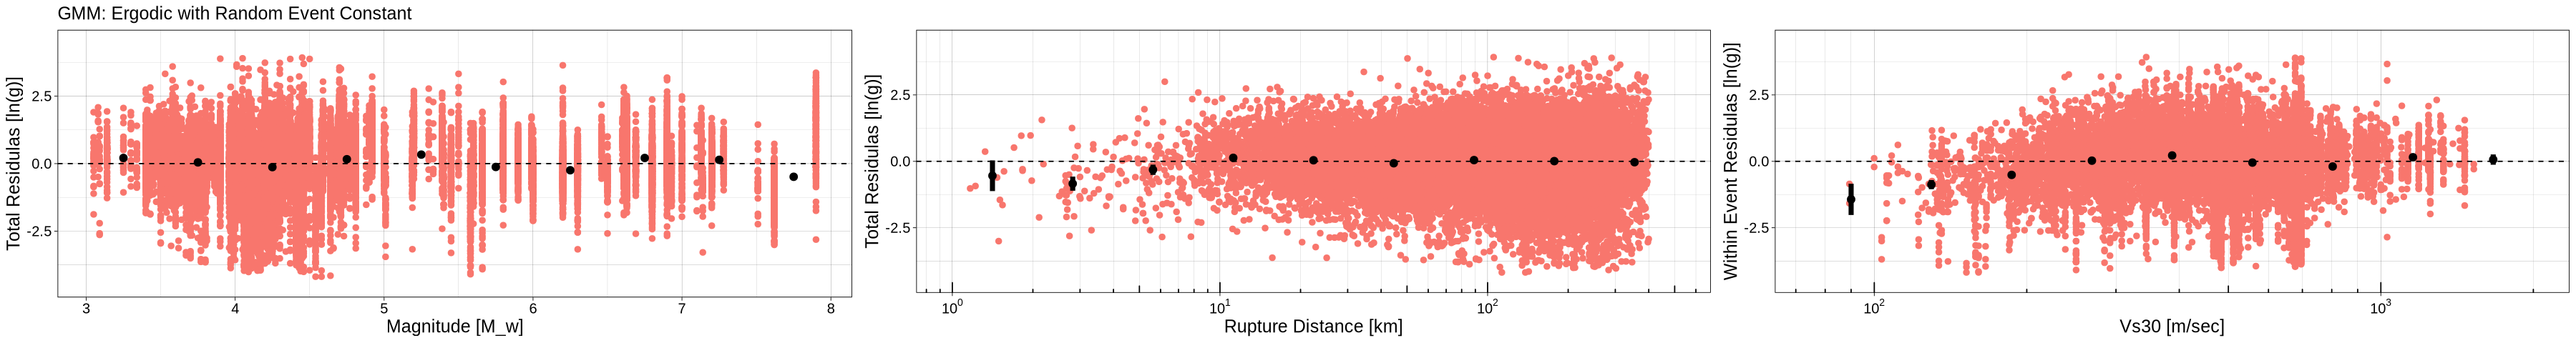

In [16]:
title_name <- 'GMM: Ergodic with Random Event Constant'
pl_gmm_erg_fxd_dW_mag <- ggplot(data=df_gmm_res, aes(x=magnitude, y=gmm_erg_fxd_dT)) +
                            geom_point(aes(color=as.factor(1)), size=2) +
                            stat_summary_bin(aes(linewidth=as.factor(1)), fun.data=mean.2th.98th, breaks=seq(3.,8.,by=0.5)) +
                            geom_hline(yintercept=0,linetype="dashed") +
                            scale_color_manual(values=c(color_dT)) +
                            labs(x='Magnitude [M_w]', y='Total Residulas [ln(g)]', 
                                 linetype='Model', linewidth='Mean Error:',
                                 title=title_name) +
                            ylim(-4.5, 4.5) +
                            theme(plot.title=element_text(size=size_title),  axis.title=element_text(size=size_title), 
                                  axis.text.y=element_text(size=size_text),  axis.text.x=element_text(size=size_text),
                                  legend.title=element_text(size=size_text), legend.text=element_text(size=size_text)) +
                            theme(legend.position = "none")

pl_gmm_erg_fxd_dW_rrup <- ggplot(data=df_gmm_res, aes(x=rrup, y=gmm_erg_fxd_dT)) +
                            geom_point(aes(color=as.factor(1)), size=2) +
                            stat_summary_bin(aes(linewidth=as.factor(1)), fun.data=mean.2th.98th, breaks=logspace(log10(1),log10(500),10)) +
                            geom_hline(yintercept=0,linetype="dashed") +
                            scale_color_manual(values=c(color_dT)) +
                            scale_x_log10(breaks=breaks_log,  minor_breaks=breaks_log_minor,
                                          labels=trans_format("log10", math_format(10^.x)), 
                                          limits=c(1, 500)) +
                            annotation_logticks(sides="b") +
                            labs(x='Rupture Distance [km]', y='Total Residulas [ln(g)]', 
                                 linetype='Model', linewidth='Mean Error:', title='') +
                            ylim(-4.5, 4.5) +
                            theme(plot.title=element_text(size=size_title),  axis.title=element_text(size=size_title), 
                                  axis.text.y=element_text(size=size_text),  axis.text.x=element_text(size=size_text),
                                  legend.title=element_text(size=size_text), legend.text=element_text(size=size_text)) +
                            theme(legend.position = "none")

pl_gmm_erg_fxd_dW_vs30 <- ggplot(data=df_gmm_res, aes(x=vs30, y=gmm_erg_fxd_dT)) +
                            geom_point(aes(color=as.factor(1)), size=2) +
                            stat_summary_bin(aes(linewidth=as.factor(1)), fun.data=mean.2th.98th, breaks=logspace(log10(75),log10(2000),10)) +
                            geom_hline(yintercept=0,linetype="dashed") +
                            scale_color_manual(values=c(color_dT)) +
                            scale_x_log10(breaks=breaks_log,  minor_breaks=breaks_log_minor,
                                          labels=trans_format("log10", math_format(10^.x)), 
                                          limits=c(75, 2000)) +
                            annotation_logticks(sides="b") +
                            labs(x='Vs30 [m/sec]', y='Within Event Residulas [ln(g)]', 
                                 linetype='Model', linewidth='Mean Error:', title='') +
                            ylim(-4.5, 4.5) +
                            theme(plot.title=element_text(size=size_title),  axis.title=element_text(size=size_title), 
                                  axis.text.y=element_text(size=size_text),  axis.text.x=element_text(size=size_text),
                                  legend.title=element_text(size=size_text), legend.text=element_text(size=size_text)) +
                            theme(legend.position = "none")

options(repr.plot.width=30, repr.plot.height=4)
ggarrange(pl_gmm_erg_fxd_dW_mag, pl_gmm_erg_fxd_dW_rrup, pl_gmm_erg_fxd_dW_vs30, ncol = 3, nrow = 1)

#### Ergodic Model: Random Event Constant

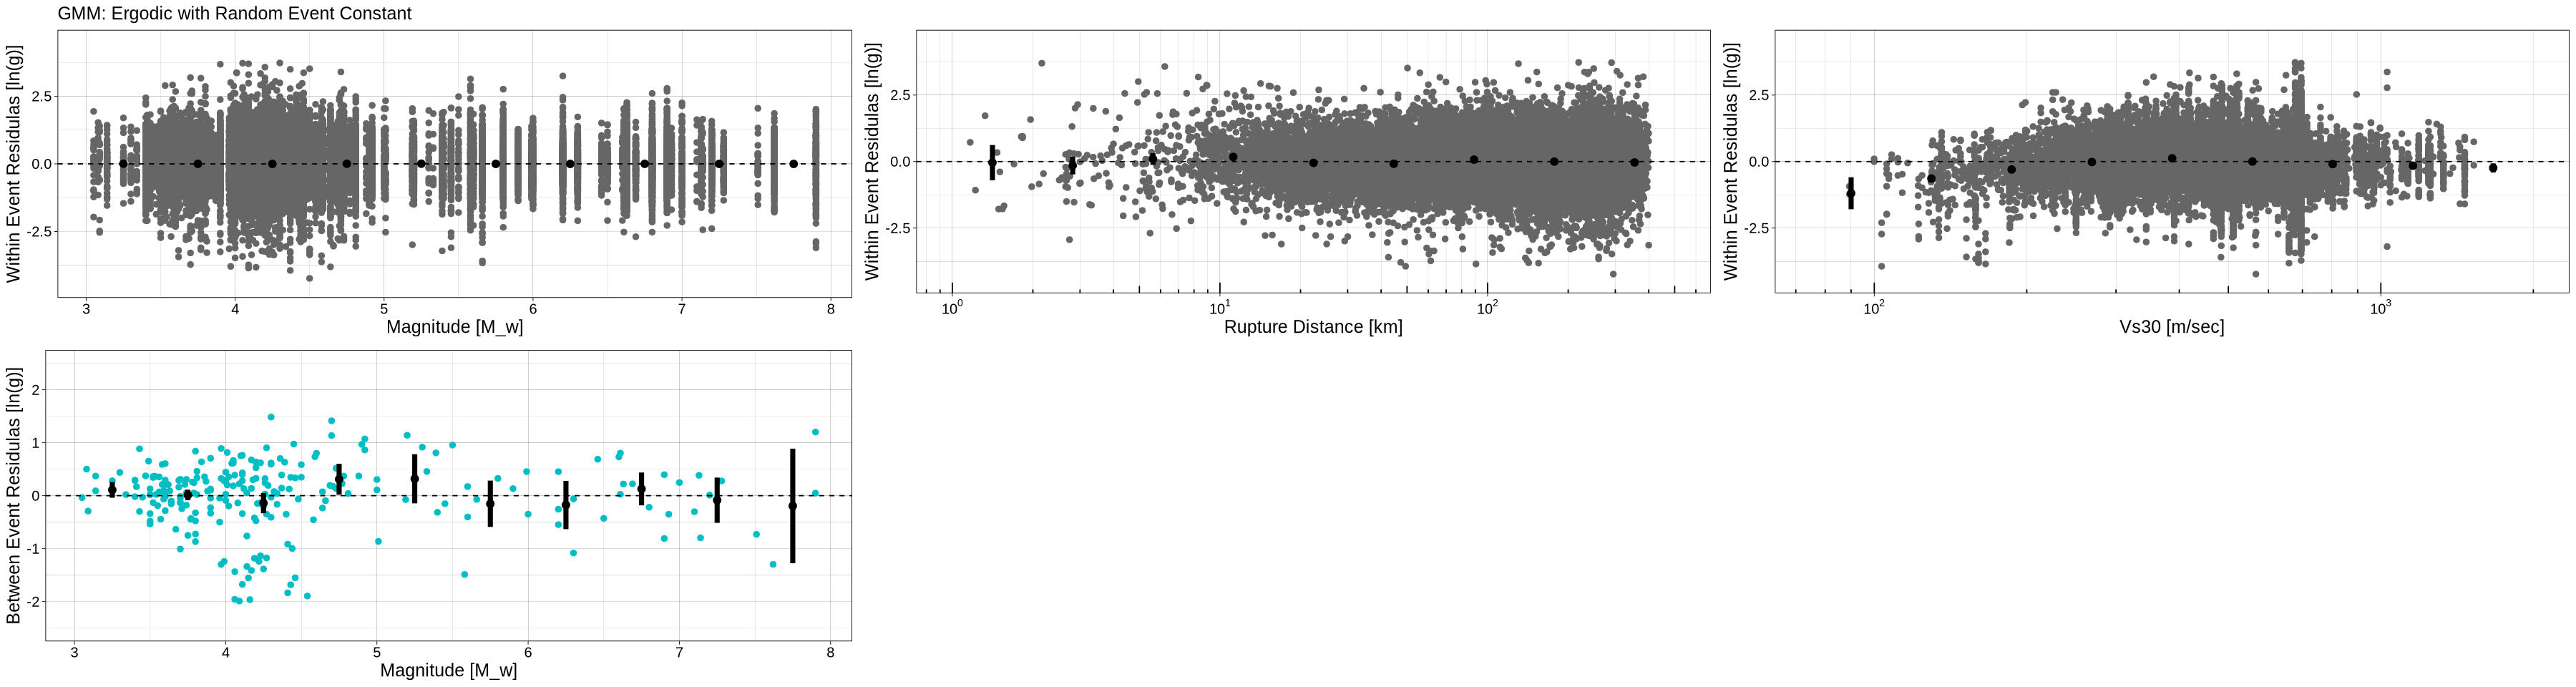

In [17]:
title_name <- 'GMM: Ergodic with Random Event Constant'
pl_gmm_erg_rnd_ceq_dW_mag <- ggplot(data=df_gmm_res, aes(x=magnitude, y=gmm_erg_rnd_ceq_dW)) +
                                geom_point(aes(color=as.factor(1)), size=2) +
                                stat_summary_bin(aes(linewidth=as.factor(1)), fun.data=mean.2th.98th, breaks=seq(3.,8.,by=0.5)) +
                                geom_hline(yintercept=0,linetype="dashed") +
                                scale_color_manual(values=c(color_dW)) +
                                labs(x='Magnitude [M_w]', y='Within Event Residulas [ln(g)]', 
                                     linetype='Model', linewidth='Mean Error:',
                                     title=title_name) +
                                ylim(-4.5, 4.5) +
                                theme(plot.title=element_text(size=size_title),  axis.title=element_text(size=size_title), 
                                      axis.text.y=element_text(size=size_text),  axis.text.x=element_text(size=size_text),
                                      legend.title=element_text(size=size_text), legend.text=element_text(size=size_text)) +
                                theme(legend.position = "none")

pl_gmm_erg_rnd_ceq_dW_rrup <- ggplot(data=df_gmm_res, aes(x=rrup, y=gmm_erg_rnd_ceq_dW)) +
                                geom_point(aes(color=as.factor(1)), size=2) +
                                stat_summary_bin(aes(linewidth=as.factor(1)), fun.data=mean.2th.98th, breaks=logspace(log10(1),log10(500),10)) +
                                geom_hline(yintercept=0,linetype="dashed") +
                                scale_color_manual(values=c(color_dW)) +
                                scale_x_log10(breaks=breaks_log,  minor_breaks=breaks_log_minor,
                                              labels=trans_format("log10", math_format(10^.x)), 
                                              limits=c(1, 500)) +
                                annotation_logticks(sides="b") +
                                labs(x='Rupture Distance [km]', y='Within Event Residulas [ln(g)]', 
                                     linetype='Model', linewidth='Mean Error:', title='') +
                                ylim(-4.5, 4.5) +
                                theme(plot.title=element_text(size=size_title),  axis.title=element_text(size=size_title), 
                                      axis.text.y=element_text(size=size_text),  axis.text.x=element_text(size=size_text),
                                      legend.title=element_text(size=size_text), legend.text=element_text(size=size_text)) +
                                theme(legend.position = "none")

pl_gmm_erg_rnd_ceq_dW_vs30 <- ggplot(data=df_gmm_res, aes(x=vs30, y=gmm_erg_rnd_ceq_dW)) +
                                geom_point(aes(color=as.factor(1)), size=2) +
                                stat_summary_bin(aes(linewidth=as.factor(1)), fun.data=mean.2th.98th, breaks=logspace(log10(75),log10(2000),10)) +
                                geom_hline(yintercept=0,linetype="dashed") +
                                scale_color_manual(values=c(color_dW)) +
                                scale_x_log10(breaks=breaks_log,  minor_breaks=breaks_log_minor,
                                              labels=trans_format("log10", math_format(10^.x)), 
                                              limits=c(75, 2000)) +
                                annotation_logticks(sides="b") +
                                labs(x='Vs30 [m/sec]', y='Within Event Residulas [ln(g)]', 
                                     linetype='Model', linewidth='Mean Error:', title='') +
                                ylim(-4.5, 4.5) +
                                theme(plot.title=element_text(size=size_title),  axis.title=element_text(size=size_title), 
                                      axis.text.y=element_text(size=size_text),  axis.text.x=element_text(size=size_text),
                                      legend.title=element_text(size=size_text), legend.text=element_text(size=size_text)) +
                                theme(legend.position = "none")

pl_gmm_erg_rnd_ceq_dB_mag <- ggplot(data=df_gmm_reff_eq, aes(x=magnitude, y=gmm_erg_rnd_ceq_dB)) +
                                geom_point(aes(color=as.factor(1)), size=2) +
                                stat_summary_bin(aes(linewidth=as.factor(1)), fun.data=mean.2th.98th, breaks=seq(3.,8.,by=0.5)) +
                                geom_hline(yintercept=0,linetype="dashed") +
                                scale_color_manual(values=c(color_dB)) +
                                labs(x='Magnitude [M_w]', y='Between Event Residulas [ln(g)]', 
                                     linetype='Model', linewidth='Mean Error:') +
                                ylim(-2.5, 2.5) +
                                theme(plot.title=element_text(size=size_title),  axis.title=element_text(size=size_title), 
                                      axis.text.y=element_text(size=size_text),  axis.text.x=element_text(size=size_text),
                                      legend.title=element_text(size=size_text), legend.text=element_text(size=size_text)) +
                                theme(legend.position = "none")


options(repr.plot.width=30, repr.plot.height=8)
ggarrange(ggarrange(pl_gmm_erg_rnd_ceq_dW_mag, pl_gmm_erg_rnd_ceq_dW_rrup, pl_gmm_erg_rnd_ceq_dW_vs30, ncol = 3, nrow = 1),
          ggarrange(pl_gmm_erg_rnd_ceq_dB_mag,                                                         ncol = 3, nrow = 1),
          ncol = 1, nrow = 2)

#### Ergodic Model: Random Event Constant + Random Event Distance Term

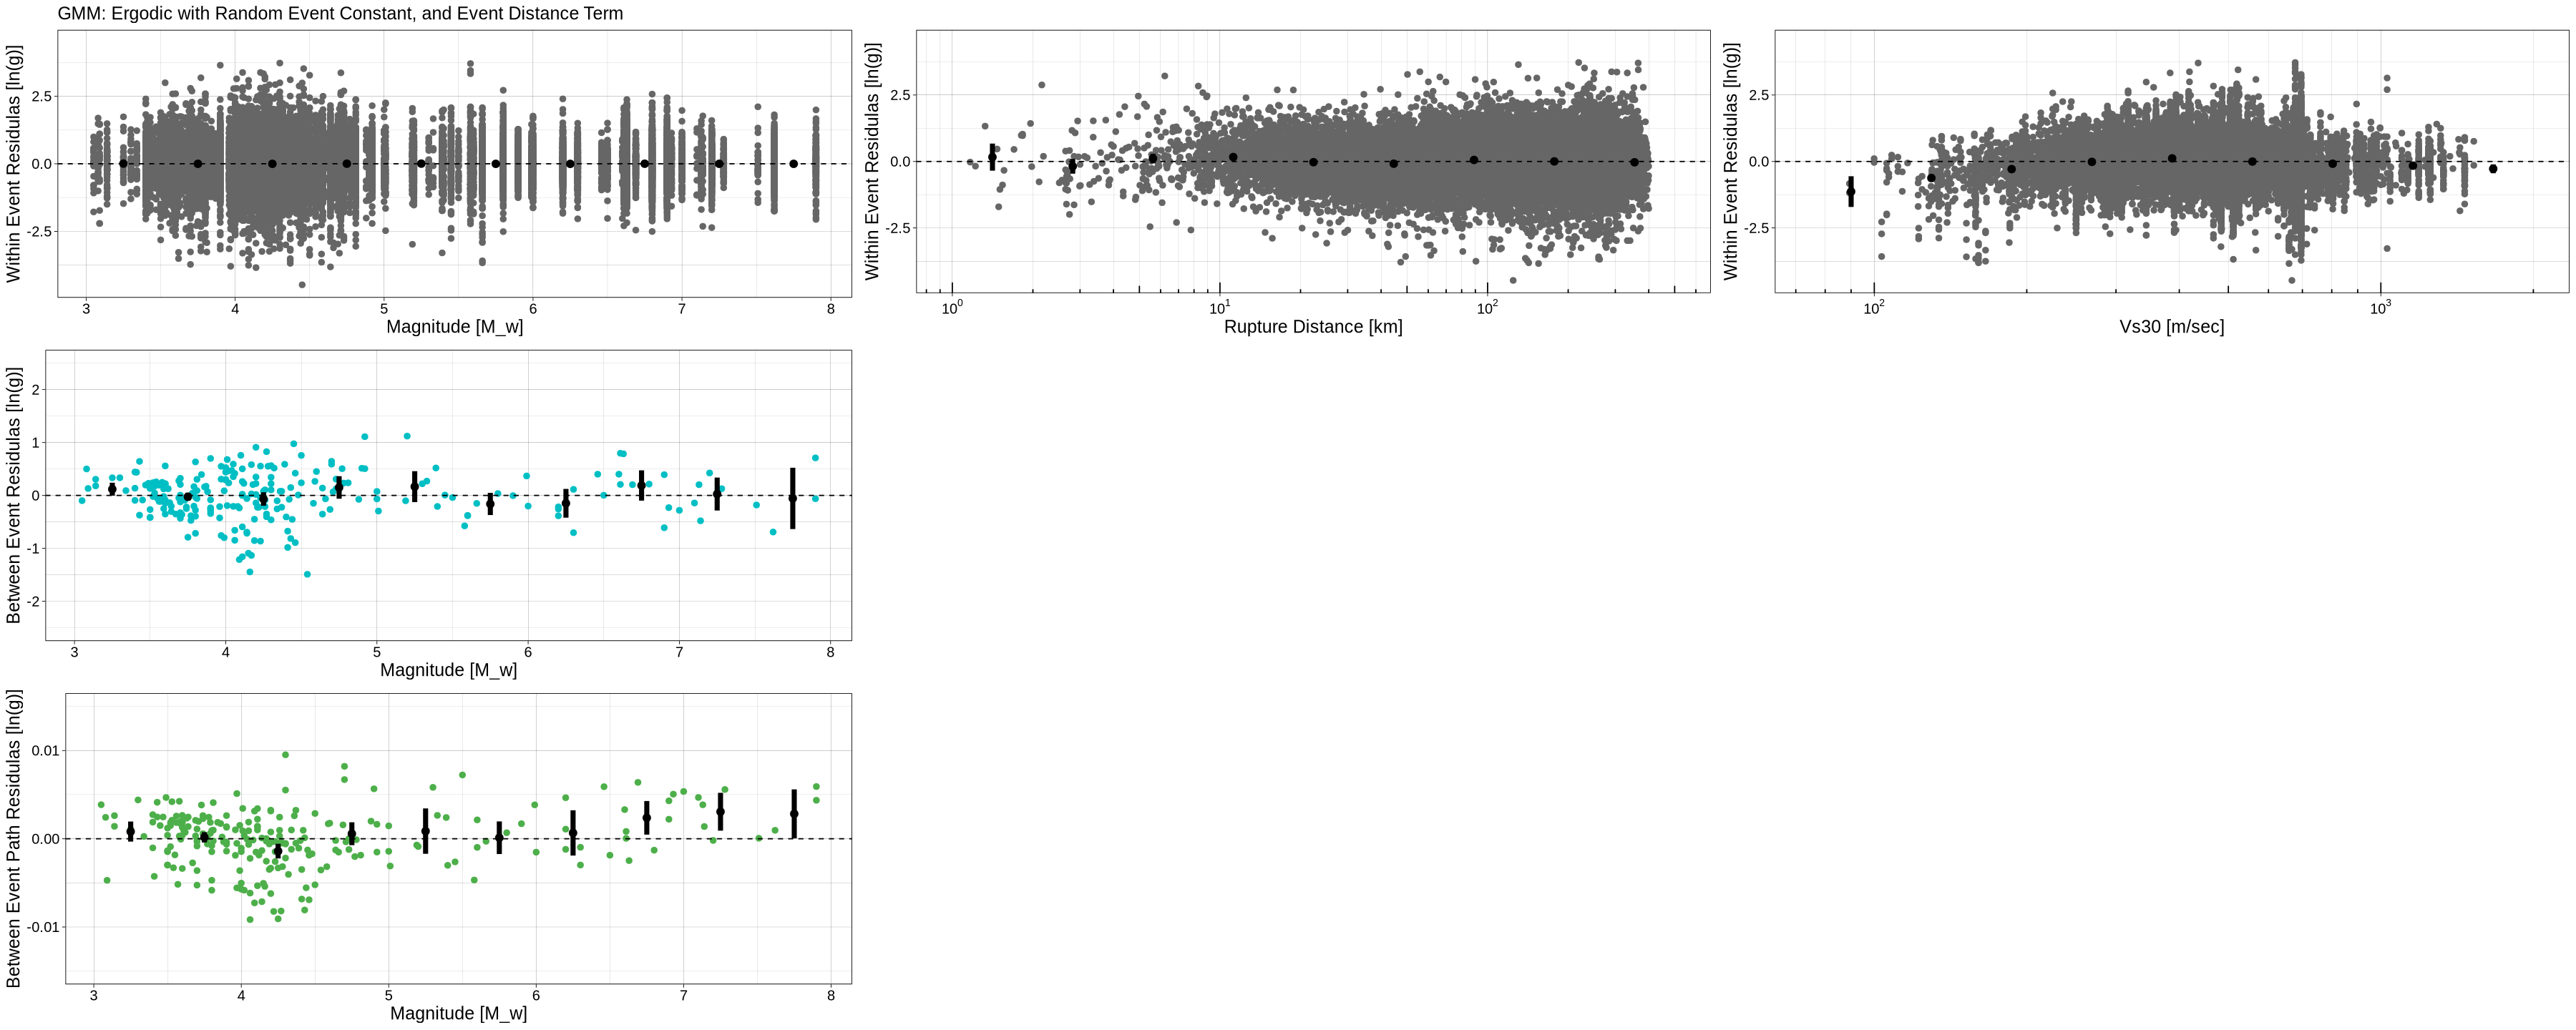

In [18]:
title_name <- 'GMM: Ergodic with Random Event Constant, and Event Distance Term'
pl_gmm_erg_rnd_ceq_req_dW_mag <- ggplot(data=df_gmm_res, aes(x=magnitude, y=gmm_erg_rnd_ceq_req_dW)) +
                                    geom_point(aes(color=as.factor(1)), size=2) +
                                    stat_summary_bin(aes(linewidth=as.factor(1)), fun.data=mean.2th.98th, breaks=seq(3.,8.,by=0.5)) +
                                    geom_hline(yintercept=0,linetype="dashed") +
                                    scale_color_manual(values=c(color_dW)) +
                                    labs(x='Magnitude [M_w]', y='Within Event Residulas [ln(g)]', 
                                         linetype='Model', linewidth='Mean Error:',
                                         title=title_name) +
                                    ylim(-4.5, 4.5) +
                                    theme(plot.title=element_text(size=size_title),  axis.title=element_text(size=size_title), 
                                          axis.text.y=element_text(size=size_text),  axis.text.x=element_text(size=size_text),
                                          legend.title=element_text(size=size_text), legend.text=element_text(size=size_text)) +
                                    theme(legend.position = "none")

pl_gmm_erg_rnd_ceq_req_dW_rrup <- ggplot(data=df_gmm_res, aes(x=rrup, y=gmm_erg_rnd_ceq_req_dW)) +
                                    geom_point(aes(color=as.factor(1)), size=2) +
                                    stat_summary_bin(aes(linewidth=as.factor(1)), fun.data=mean.2th.98th, breaks=logspace(log10(1),log10(500),10)) +
                                    geom_hline(yintercept=0,linetype="dashed") +
                                    scale_color_manual(values=c(color_dW)) +
                                    scale_x_log10(breaks=breaks_log,  minor_breaks=breaks_log_minor,
                                                  labels=trans_format("log10", math_format(10^.x)), 
                                                  limits=c(1, 500)) +
                                    annotation_logticks(sides="b") +
                                    labs(x='Rupture Distance [km]', y='Within Event Residulas [ln(g)]', 
                                         linetype='Model', linewidth='Mean Error:', title='') +
                                    ylim(-4.5, 4.5) +
                                    theme(plot.title=element_text(size=size_title),  axis.title=element_text(size=size_title), 
                                          axis.text.y=element_text(size=size_text),  axis.text.x=element_text(size=size_text),
                                          legend.title=element_text(size=size_text), legend.text=element_text(size=size_text)) +
                                    theme(legend.position = "none")

pl_gmm_erg_rnd_ceq_req_dW_vs30 <- ggplot(data=df_gmm_res, aes(x=vs30, y=gmm_erg_rnd_ceq_req_dW)) +
                                    geom_point(aes(color=as.factor(1)), size=2) +
                                    stat_summary_bin(aes(linewidth=as.factor(1)), fun.data=mean.2th.98th, breaks=logspace(log10(75),log10(2000),10)) +
                                    geom_hline(yintercept=0,linetype="dashed") +
                                    scale_color_manual(values=c(color_dW)) +
                                    scale_x_log10(breaks=breaks_log,  minor_breaks=breaks_log_minor,
                                                  labels=trans_format("log10", math_format(10^.x)), 
                                                  limits=c(75, 2000)) +
                                    annotation_logticks(sides="b") +
                                    labs(x='Vs30 [m/sec]', y='Within Event Residulas [ln(g)]', 
                                         linetype='Model', linewidth='Mean Error:', title='') +
                                    ylim(-4.5, 4.5) +
                                    theme(plot.title=element_text(size=size_title),  axis.title=element_text(size=size_title), 
                                          axis.text.y=element_text(size=size_text),  axis.text.x=element_text(size=size_text),
                                          legend.title=element_text(size=size_text), legend.text=element_text(size=size_text)) +
                                    theme(legend.position = "none")

pl_gmm_erg_rnd_ceq_req_dB_mag <- ggplot(data=df_gmm_reff_eq, aes(x=magnitude, y=gmm_erg_rnd_ceq_req_dB)) +
                                    geom_point(aes(color=as.factor(1)), size=2) +
                                    stat_summary_bin(aes(linewidth=as.factor(1)), fun.data=mean.2th.98th, breaks=seq(3.,8.,by=0.5)) +
                                    geom_hline(yintercept=0,linetype="dashed") +
                                    scale_color_manual(values=c(color_dB)) +
                                    labs(x='Magnitude [M_w]', y='Between Event Residulas [ln(g)]', 
                                         linetype='Model', linewidth='Mean Error:') +
                                    ylim(-2.5, 2.5) +
                                    theme(plot.title=element_text(size=size_title),  axis.title=element_text(size=size_title), 
                                          axis.text.y=element_text(size=size_text),  axis.text.x=element_text(size=size_text),
                                          legend.title=element_text(size=size_text), legend.text=element_text(size=size_text)) +
                                    theme(legend.position = "none")

pl_gmm_erg_rnd_ceq_req_dBP_mag <- ggplot(data=df_gmm_reff_eq, aes(x=magnitude, y=gmm_erg_rnd_ceq_req_dBP)) +
                                    geom_point(aes(color=as.factor(1)), size=2) +
                                    stat_summary_bin(aes(linewidth=as.factor(1)), fun.data=mean.2th.98th, breaks=seq(3.,8.,by=0.5)) +
                                    geom_hline(yintercept=0,linetype="dashed") +
                                    scale_color_manual(values=c(color_dBP)) +
                                    labs(x='Magnitude [M_w]', y='Between Event Path Residulas [ln(g)]', 
                                         linetype='Model', linewidth='Mean Error:') +
                                    ylim(-0.015, 0.015) +
                                    theme(plot.title=element_text(size=size_title),  axis.title=element_text(size=size_title), 
                                          axis.text.y=element_text(size=size_text),  axis.text.x=element_text(size=size_text),
                                          legend.title=element_text(size=size_text), legend.text=element_text(size=size_text)) +
                                    theme(legend.position = "none")


options(repr.plot.width=30, repr.plot.height=12)
ggarrange(ggarrange(pl_gmm_erg_rnd_ceq_req_dW_mag,  pl_gmm_erg_rnd_ceq_req_dW_rrup, pl_gmm_erg_rnd_ceq_req_dW_vs30, ncol = 3, nrow = 1),
          ggarrange(pl_gmm_erg_rnd_ceq_req_dB_mag,                                                                  ncol = 3, nrow = 1),
          ggarrange(pl_gmm_erg_rnd_ceq_req_dBP_mag,                                                                 ncol = 3, nrow = 1),
          ncol = 1, nrow = 3)

#### Ergodic Model: Random Event Constant + Random Site Distance Term

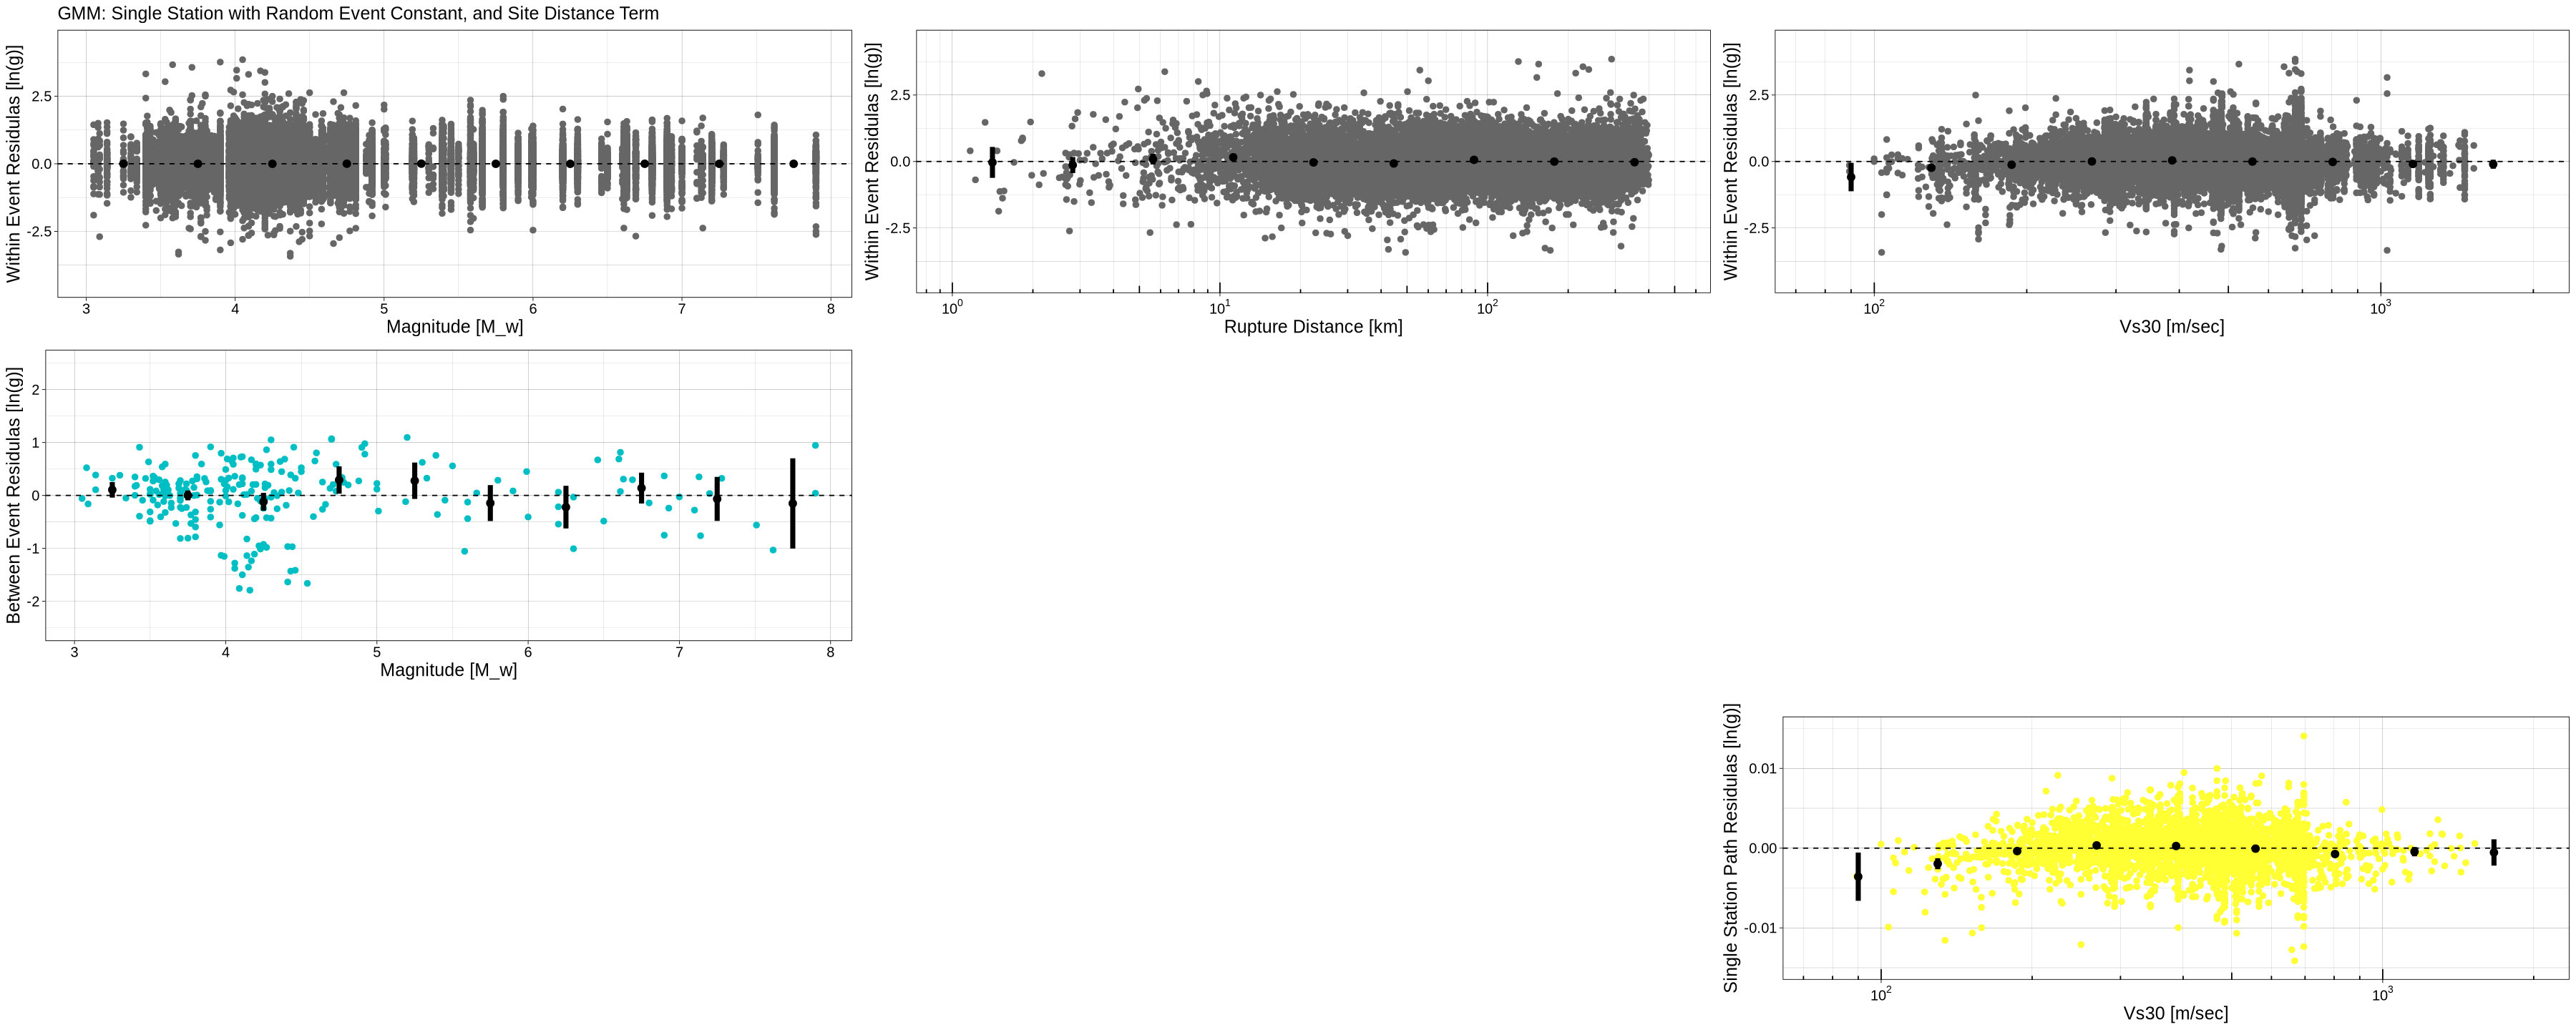

In [19]:
title_name <- 'GMM: Single Station with Random Event Constant, and Site Distance Term'
pl_gmm_erg_rnd_ceq_rst_dW_mag <- ggplot(data=df_gmm_res, aes(x=magnitude, y=gmm_erg_rnd_ceq_rst_dW)) +
                                        geom_point(aes(color=as.factor(1)), size=2) +
                                        stat_summary_bin(aes(linewidth=as.factor(1)), fun.data=mean.2th.98th, breaks=seq(3.,8.,by=0.5)) +
                                        geom_hline(yintercept=0,linetype="dashed") +
                                        scale_color_manual(values=c(color_dW)) +
                                        labs(x='Magnitude [M_w]', y='Within Event Residulas [ln(g)]', 
                                             linetype='Model', linewidth='Mean Error:',
                                             title=title_name) +
                                        ylim(-4.5, 4.5) +
                                        theme(plot.title=element_text(size=size_title),  axis.title=element_text(size=size_title), 
                                              axis.text.y=element_text(size=size_text),  axis.text.x=element_text(size=size_text),
                                              legend.title=element_text(size=size_text), legend.text=element_text(size=size_text)) +
                                        theme(legend.position = "none")

pl_gmm_erg_rnd_ceq_rst_dW_rrup <- ggplot(data=df_gmm_res, aes(x=rrup, y=gmm_erg_rnd_ceq_rst_dW)) +
                                        geom_point(aes(color=as.factor(1)), size=2) +
                                        stat_summary_bin(aes(linewidth=as.factor(1)), fun.data=mean.2th.98th, breaks=logspace(log10(1),log10(500),10)) +
                                        geom_hline(yintercept=0,linetype="dashed") +
                                        scale_color_manual(values=c(color_dW)) +
                                        scale_x_log10(breaks=breaks_log,  minor_breaks=breaks_log_minor,
                                                      labels=trans_format("log10", math_format(10^.x)), 
                                                      limits=c(1, 500)) +
                                        annotation_logticks(sides="b") +
                                        labs(x='Rupture Distance [km]', y='Within Event Residulas [ln(g)]', 
                                             linetype='Model', linewidth='Mean Error:', title='') +
                                        ylim(-4.5, 4.5) +
                                        theme(plot.title=element_text(size=size_title),  axis.title=element_text(size=size_title), 
                                              axis.text.y=element_text(size=size_text),  axis.text.x=element_text(size=size_text),
                                              legend.title=element_text(size=size_text), legend.text=element_text(size=size_text)) +
                                        theme(legend.position = "none")

pl_gmm_erg_rnd_ceq_rst_dW_vs30 <- ggplot(data=df_gmm_res, aes(x=vs30, y=gmm_erg_rnd_ceq_rst_dW)) +
                                        geom_point(aes(color=as.factor(1)), size=2) +
                                        stat_summary_bin(aes(linewidth=as.factor(1)), fun.data=mean.2th.98th, breaks=logspace(log10(75),log10(2000),10)) +
                                        geom_hline(yintercept=0,linetype="dashed") +
                                        scale_color_manual(values=c(color_dW)) +
                                        scale_x_log10(breaks=breaks_log,  minor_breaks=breaks_log_minor,
                                                      labels=trans_format("log10", math_format(10^.x)), 
                                                      limits=c(75, 2000)) +
                                        annotation_logticks(sides="b") +
                                        labs(x='Vs30 [m/sec]', y='Within Event Residulas [ln(g)]', 
                                             linetype='Model', linewidth='Mean Error:', title='') +
                                        ylim(-4.5, 4.5) +
                                        theme(plot.title=element_text(size=size_title),  axis.title=element_text(size=size_title), 
                                              axis.text.y=element_text(size=size_text),  axis.text.x=element_text(size=size_text),
                                              legend.title=element_text(size=size_text), legend.text=element_text(size=size_text)) +
                                        theme(legend.position = "none")

pl_gmm_erg_rnd_ceq_rst_dB_mag <- ggplot(data=df_gmm_reff_eq, aes(x=magnitude, y=gmm_erg_rnd_ceq_rst_dB)) +
                                        geom_point(aes(color=as.factor(1)), size=2) +
                                        stat_summary_bin(aes(linewidth=as.factor(1)), fun.data=mean.2th.98th, breaks=seq(3.,8.,by=0.5)) +
                                        geom_hline(yintercept=0,linetype="dashed") +
                                        scale_color_manual(values=c(color_dB)) +
                                        labs(x='Magnitude [M_w]', y='Between Event Residulas [ln(g)]', 
                                             linetype='Model', linewidth='Mean Error:') +
                                        ylim(-2.5, 2.5) +
                                        theme(plot.title=element_text(size=size_title),  axis.title=element_text(size=size_title), 
                                              axis.text.y=element_text(size=size_text),  axis.text.x=element_text(size=size_text),
                                              legend.title=element_text(size=size_text), legend.text=element_text(size=size_text)) +
                                        theme(legend.position = "none")

pl_gmm_erg_rnd_ceq_rst_dSP2SP_vs30 <- ggplot(data=df_gmm_reff_st, aes(x=vs30, y=gmm_erg_rnd_ceq_rst_dSP2SP)) +
                                        geom_point(aes(color=as.factor(1)), size=2) +
                                        stat_summary_bin(aes(linewidth=as.factor(1)), fun.data=mean.2th.98th, breaks=logspace(log10(75),log10(2000),10)) +
                                        geom_hline(yintercept=0,linetype="dashed") +
                                        scale_color_manual(values=c(color_dSP2SP)) +
                                        scale_x_log10(breaks=breaks_log,  minor_breaks=breaks_log_minor,
                                                      labels=trans_format("log10", math_format(10^.x)), 
                                                      limits=c(75, 2000)) +
                                        annotation_logticks(sides="b") +
                                        labs(x='Vs30 [m/sec]', y='Single Station Path Residulas [ln(g)]', 
                                             linetype='Model', linewidth='Mean Error:', title='') +
                                        ylim(-0.015, 0.015) +
                                        theme(plot.title=element_text(size=size_title),  axis.title=element_text(size=size_title), 
                                              axis.text.y=element_text(size=size_text),  axis.text.x=element_text(size=size_text),
                                              legend.title=element_text(size=size_text), legend.text=element_text(size=size_text)) +
                                        theme(legend.position = "none")


options(repr.plot.width=30, repr.plot.height=12)
ggarrange(ggarrange(pl_gmm_erg_rnd_ceq_rst_dW_mag,     pl_gmm_erg_rnd_ceq_rst_dW_rrup, pl_gmm_erg_rnd_ceq_rst_dW_vs30,     ncol = 3, nrow = 1),
          ggarrange(pl_gmm_erg_rnd_ceq_rst_dB_mag,                                                                         ncol = 3, nrow = 1),
          ggarrange(ggplot() + theme_void(),           ggplot() + theme_void(),        pl_gmm_erg_rnd_ceq_rst_dSP2SP_vs30, ncol = 3, nrow = 1),
          ncol = 1, nrow = 3)

#### Signle Station Model: Random Event Constant + Random Event Distance Term + Random Site Constant 

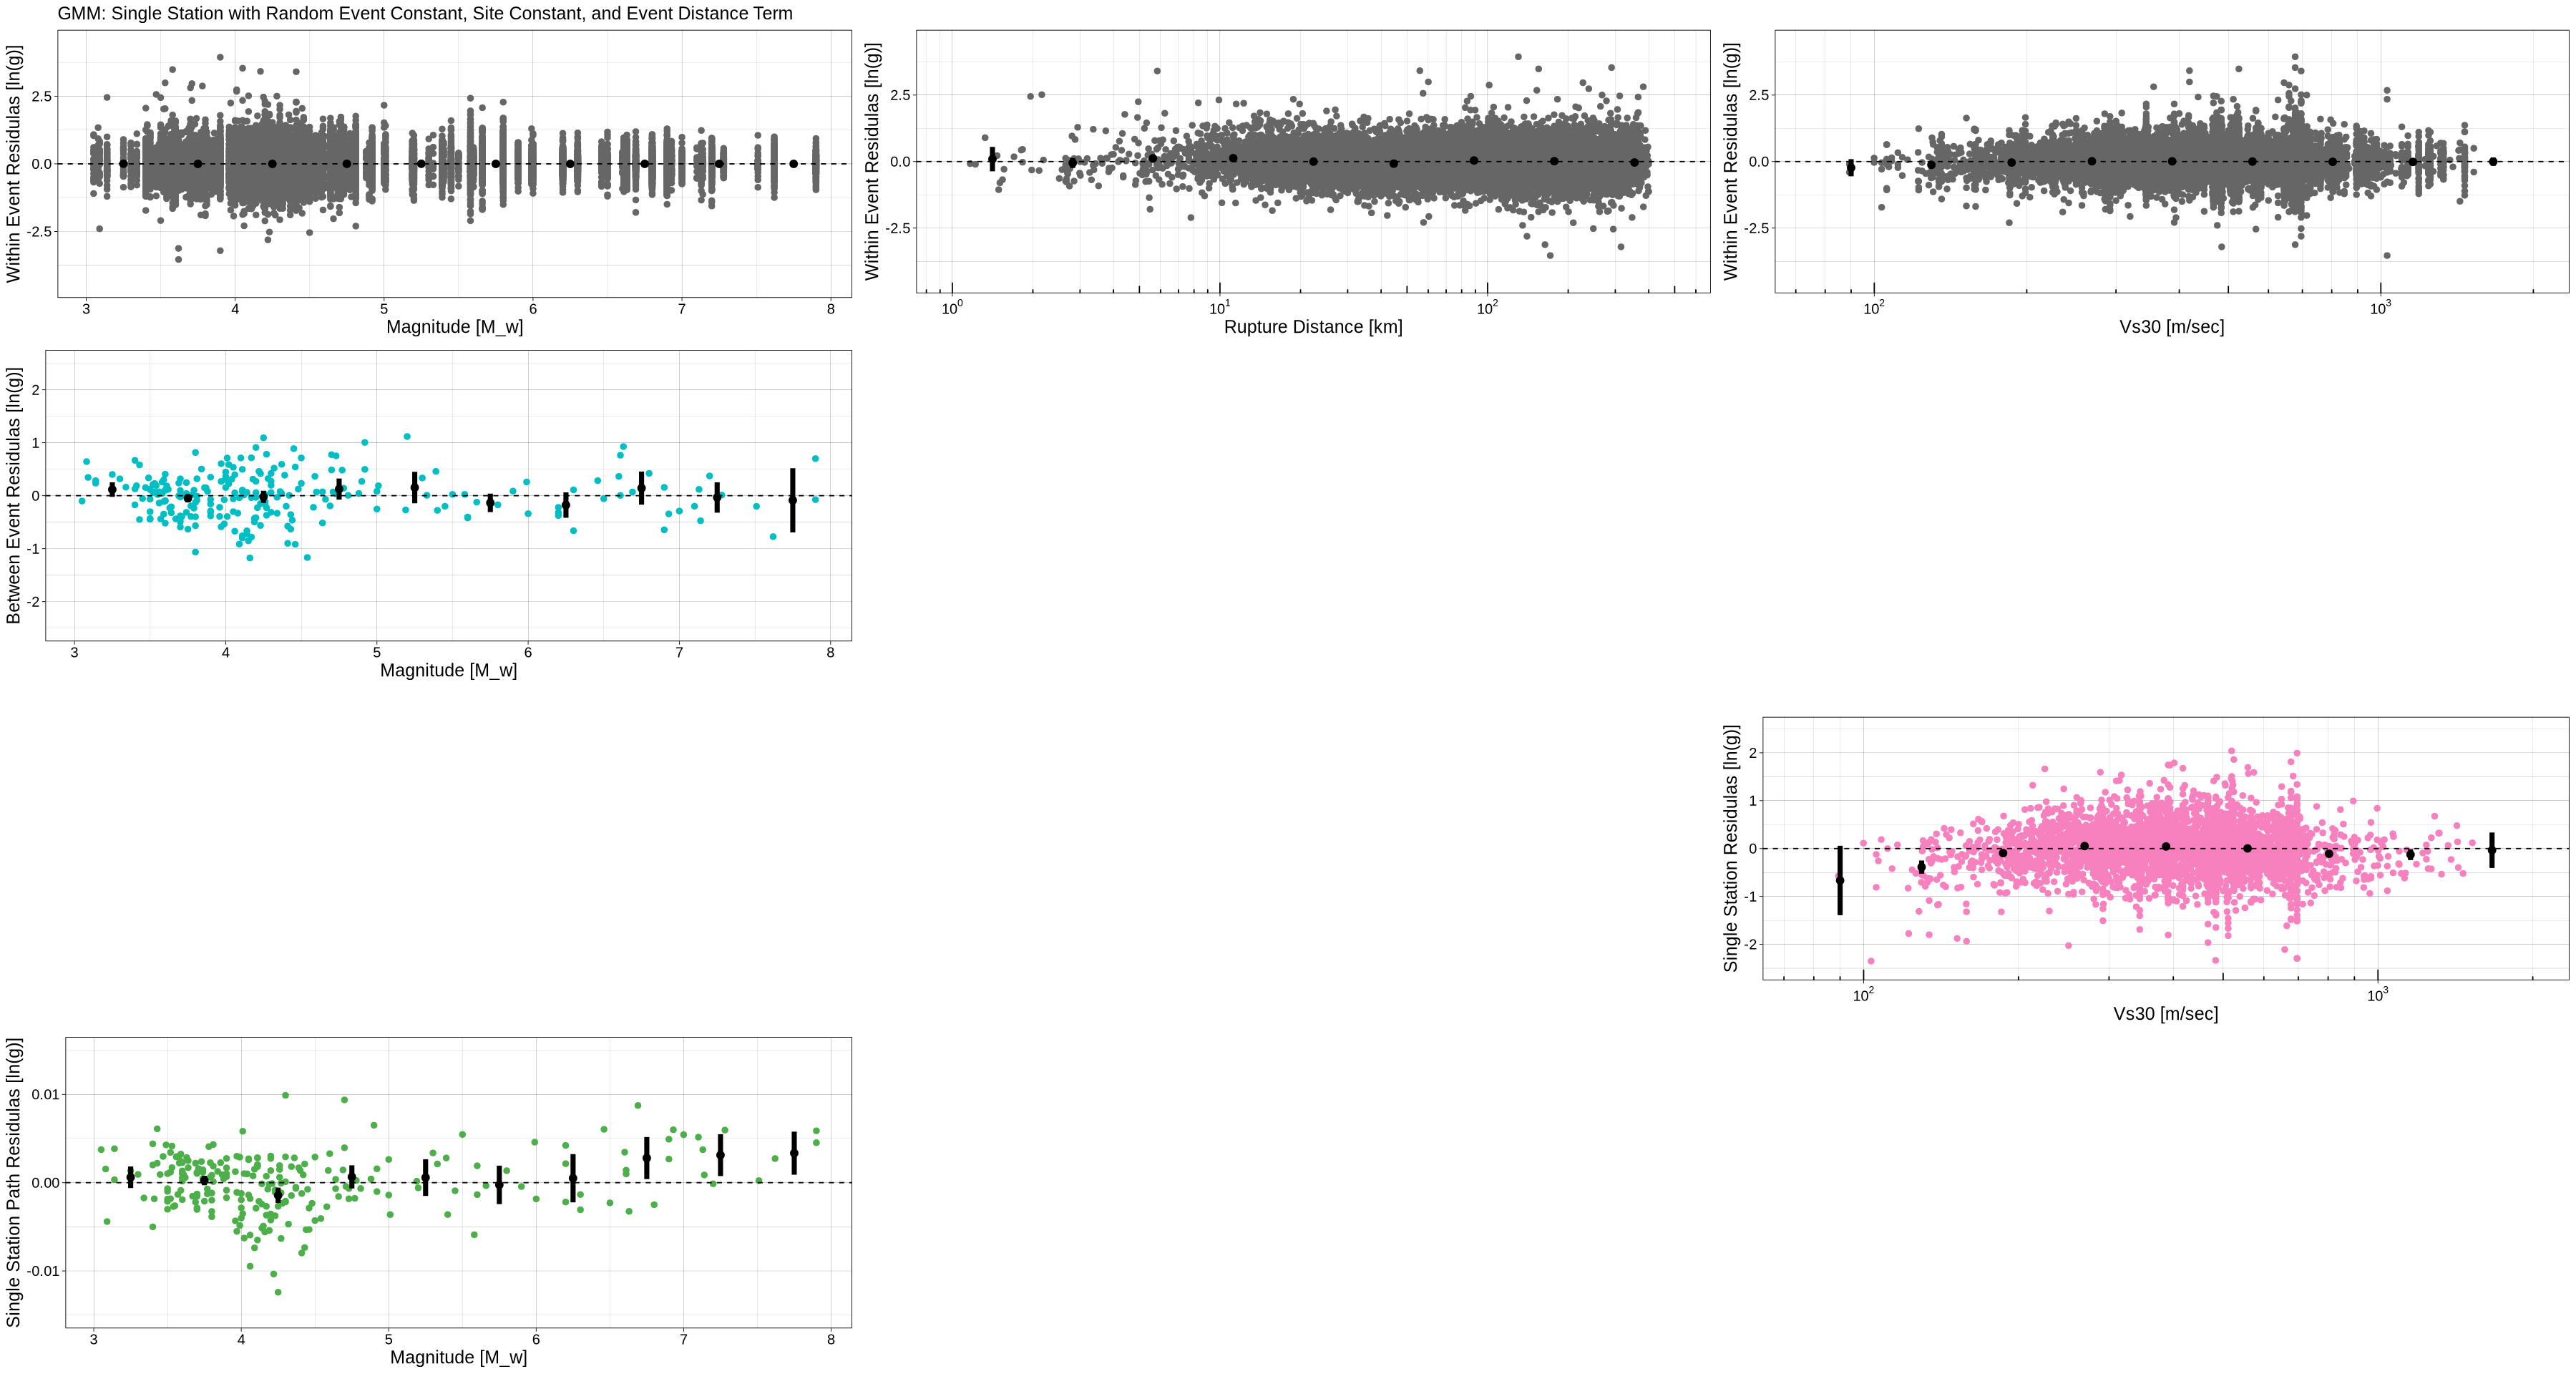

In [20]:
title_name <- 'GMM: Single Station with Random Event Constant, Site Constant, and Event Distance Term'
pl_gmm_ss_rnd_ceq_cst_req_dW_mag <- ggplot(data=df_gmm_res, aes(x=magnitude, y=gmm_ss_rnd_ceq_cst_req_dW)) +
                                        geom_point(aes(color=as.factor(1)), size=2) +
                                        stat_summary_bin(aes(linewidth=as.factor(1)), fun.data=mean.2th.98th, breaks=seq(3.,8.,by=0.5)) +
                                        geom_hline(yintercept=0,linetype="dashed") +
                                        scale_color_manual(values=c(color_dW)) +
                                        labs(x='Magnitude [M_w]', y='Within Event Residulas [ln(g)]', 
                                             linetype='Model', linewidth='Mean Error:',
                                             title=title_name) +
                                        ylim(-4.5, 4.5) +
                                        theme(plot.title=element_text(size=size_title),  axis.title=element_text(size=size_title), 
                                              axis.text.y=element_text(size=size_text),  axis.text.x=element_text(size=size_text),
                                              legend.title=element_text(size=size_text), legend.text=element_text(size=size_text)) +
                                        theme(legend.position = "none")

pl_gmm_ss_rnd_ceq_cst_req_dW_rrup <- ggplot(data=df_gmm_res, aes(x=rrup, y=gmm_ss_rnd_ceq_cst_req_dW)) +
                                        geom_point(aes(color=as.factor(1)), size=2) +
                                        stat_summary_bin(aes(linewidth=as.factor(1)), fun.data=mean.2th.98th, breaks=logspace(log10(1),log10(500),10)) +
                                        geom_hline(yintercept=0,linetype="dashed") +
                                        scale_color_manual(values=c(color_dW)) +
                                        scale_x_log10(breaks=breaks_log,  minor_breaks=breaks_log_minor,
                                                      labels=trans_format("log10", math_format(10^.x)), 
                                                      limits=c(1, 500)) +
                                        annotation_logticks(sides="b") +
                                        labs(x='Rupture Distance [km]', y='Within Event Residulas [ln(g)]', 
                                             linetype='Model', linewidth='Mean Error:', title='') +
                                        ylim(-4.5, 4.5) +
                                        theme(plot.title=element_text(size=size_title),  axis.title=element_text(size=size_title), 
                                              axis.text.y=element_text(size=size_text),  axis.text.x=element_text(size=size_text),
                                              legend.title=element_text(size=size_text), legend.text=element_text(size=size_text)) +
                                        theme(legend.position = "none")

pl_gmm_ss_rnd_ceq_cst_req_dW_vs30 <- ggplot(data=df_gmm_res, aes(x=vs30, y=gmm_ss_rnd_ceq_cst_req_dW)) +
                                        geom_point(aes(color=as.factor(1)), size=2) +
                                        stat_summary_bin(aes(linewidth=as.factor(1)), fun.data=mean.2th.98th, breaks=logspace(log10(75),log10(2000),10)) +
                                        geom_hline(yintercept=0,linetype="dashed") +
                                        scale_color_manual(values=c(color_dW)) +
                                        scale_x_log10(breaks=breaks_log,  minor_breaks=breaks_log_minor,
                                                      labels=trans_format("log10", math_format(10^.x)), 
                                                      limits=c(75, 2000)) +
                                        annotation_logticks(sides="b") +
                                        labs(x='Vs30 [m/sec]', y='Within Event Residulas [ln(g)]', 
                                             linetype='Model', linewidth='Mean Error:', title='') +
                                        ylim(-4.5, 4.5) +
                                        theme(plot.title=element_text(size=size_title),  axis.title=element_text(size=size_title), 
                                              axis.text.y=element_text(size=size_text),  axis.text.x=element_text(size=size_text),
                                              legend.title=element_text(size=size_text), legend.text=element_text(size=size_text)) +
                                        theme(legend.position = "none")

pl_gmm_ss_rnd_ceq_cst_req_dB_mag <- ggplot(data=df_gmm_reff_eq, aes(x=magnitude, y=gmm_ss_rnd_ceq_cst_req_dB)) +
                                        geom_point(aes(color=as.factor(1)), size=2) +
                                        stat_summary_bin(aes(linewidth=as.factor(1)), fun.data=mean.2th.98th, breaks=seq(3.,8.,by=0.5)) +
                                        geom_hline(yintercept=0,linetype="dashed") +
                                        scale_color_manual(values=c(color_dB)) +
                                        labs(x='Magnitude [M_w]', y='Between Event Residulas [ln(g)]', 
                                             linetype='Model', linewidth='Mean Error:') +
                                        ylim(-2.5, 2.5) +
                                        theme(plot.title=element_text(size=size_title),  axis.title=element_text(size=size_title), 
                                              axis.text.y=element_text(size=size_text),  axis.text.x=element_text(size=size_text),
                                              legend.title=element_text(size=size_text), legend.text=element_text(size=size_text)) +
                                        theme(legend.position = "none")

pl_gmm_ss_rnd_ceq_cst_req_dS2S_vs30 <- ggplot(data=df_gmm_reff_st, aes(x=vs30, y=gmm_ss_rnd_ceq_cst_req_dS2S)) +
                                        geom_point(aes(color=as.factor(1)), size=2) +
                                        stat_summary_bin(aes(linewidth=as.factor(1)), fun.data=mean.2th.98th, breaks=logspace(log10(75),log10(2000),10)) +
                                        geom_hline(yintercept=0,linetype="dashed") +
                                        scale_color_manual(values=c(color_dS2S)) +
                                        scale_x_log10(breaks=breaks_log,  minor_breaks=breaks_log_minor,
                                                      labels=trans_format("log10", math_format(10^.x)), 
                                                      limits=c(75, 2000)) +
                                        annotation_logticks(sides="b") +
                                        labs(x='Vs30 [m/sec]', y='Single Station Residulas [ln(g)]', 
                                             linetype='Model', linewidth='Mean Error:', title='') +
                                        ylim(-2.5, 2.5) +
                                        theme(plot.title=element_text(size=size_title),  axis.title=element_text(size=size_title), 
                                              axis.text.y=element_text(size=size_text),  axis.text.x=element_text(size=size_text),
                                              legend.title=element_text(size=size_text), legend.text=element_text(size=size_text)) +
                                        theme(legend.position = "none")

pl_gmm_ss_rnd_ceq_cst_req_dBP_mag <- ggplot(data=df_gmm_reff_eq, aes(x=magnitude, y=gmm_ss_rnd_ceq_cst_req_dBP)) +
                                        geom_point(aes(color=as.factor(1)), size=2) +
                                        stat_summary_bin(aes(linewidth=as.factor(1)), fun.data=mean.2th.98th, breaks=seq(3.,8.,by=0.5)) +
                                        geom_hline(yintercept=0,linetype="dashed") +
                                        scale_color_manual(values=c(color_dBP)) +
                                        labs(x='Magnitude [M_w]', y='Single Station Path Residulas [ln(g)]', 
                                             linetype='Model', linewidth='Mean Error:') +
                                        ylim(-0.015, 0.015) +
                                        theme(plot.title=element_text(size=size_title),  axis.title=element_text(size=size_title), 
                                              axis.text.y=element_text(size=size_text),  axis.text.x=element_text(size=size_text),
                                              legend.title=element_text(size=size_text), legend.text=element_text(size=size_text)) +
                                        theme(legend.position = "none")


options(repr.plot.width=30, repr.plot.height=16)
ggarrange(ggarrange(pl_gmm_ss_rnd_ceq_cst_req_dW_mag,  pl_gmm_ss_rnd_ceq_cst_req_dW_rrup, pl_gmm_ss_rnd_ceq_cst_req_dW_vs30,   ncol = 3, nrow = 1),
          ggarrange(pl_gmm_ss_rnd_ceq_cst_req_dB_mag,                                                                         ncol = 3, nrow = 1),
          ggarrange(ggplot() + theme_void(),           ggplot() + theme_void(),           pl_gmm_ss_rnd_ceq_cst_req_dS2S_vs30, ncol = 3, nrow = 1),
          ggarrange(pl_gmm_ss_rnd_ceq_cst_req_dBP_mag,                                                                         ncol = 3, nrow = 1),
          ncol = 1, nrow = 4)

#### Signle Station Model: Random Event Constant + Random Station Distance Term + Random Site Constant 

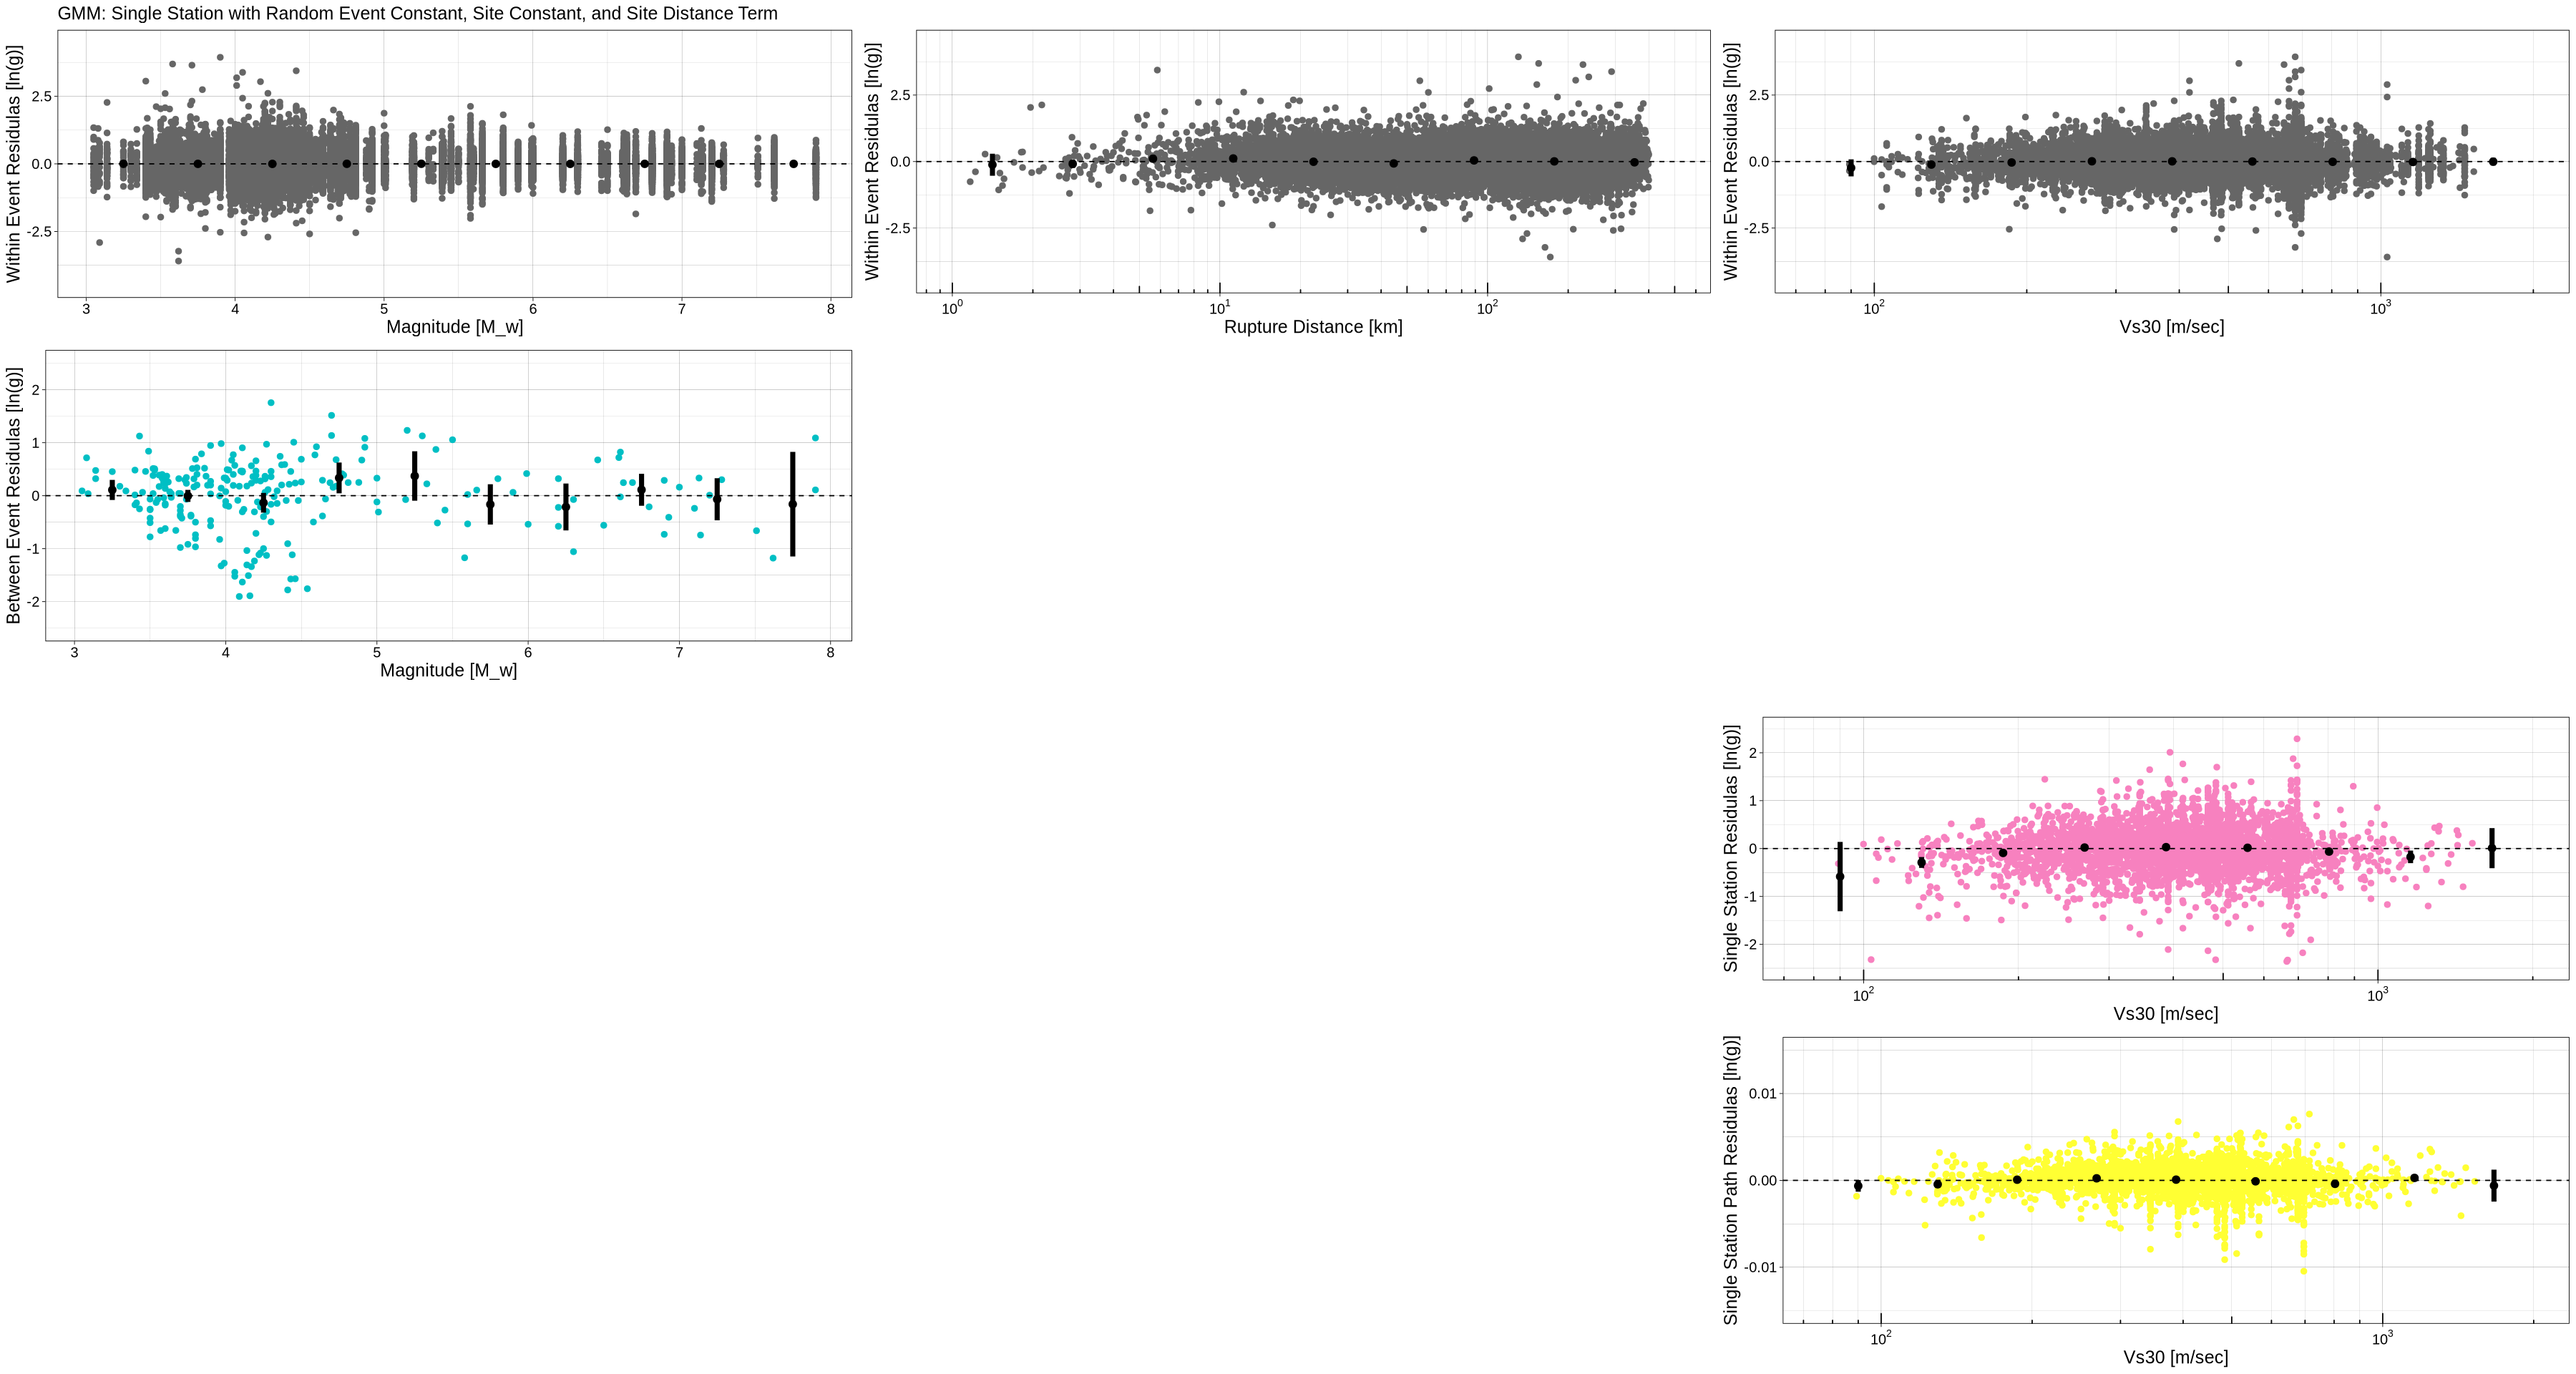

In [21]:
title_name <- 'GMM: Single Station with Random Event Constant, Site Constant, and Site Distance Term'
pl_gmm_ss_rnd_ceq_cst_rst_dW_mag <- ggplot(data=df_gmm_res, aes(x=magnitude, y=gmm_ss_rnd_ceq_cst_rst_dW)) +
                                        geom_point(aes(color=as.factor(1)), size=2) +
                                        stat_summary_bin(aes(linewidth=as.factor(1)), fun.data=mean.2th.98th, breaks=seq(3.,8.,by=0.5)) +
                                        geom_hline(yintercept=0,linetype="dashed") +
                                        scale_color_manual(values=c(color_dW)) +
                                        labs(x='Magnitude [M_w]', y='Within Event Residulas [ln(g)]', 
                                             linetype='Model', linewidth='Mean Error:',
                                             title=title_name) +
                                        ylim(-4.5, 4.5) +
                                        theme(plot.title=element_text(size=size_title),  axis.title=element_text(size=size_title), 
                                              axis.text.y=element_text(size=size_text),  axis.text.x=element_text(size=size_text),
                                              legend.title=element_text(size=size_text), legend.text=element_text(size=size_text)) +
                                        theme(legend.position = "none")

pl_gmm_ss_rnd_ceq_cst_rst_dW_rrup <- ggplot(data=df_gmm_res, aes(x=rrup, y=gmm_ss_rnd_ceq_cst_rst_dW)) +
                                        geom_point(aes(color=as.factor(1)), size=2) +
                                        stat_summary_bin(aes(linewidth=as.factor(1)), fun.data=mean.2th.98th, breaks=logspace(log10(1),log10(500),10)) +
                                        geom_hline(yintercept=0,linetype="dashed") +
                                        scale_color_manual(values=c(color_dW)) +
                                        scale_x_log10(breaks=breaks_log,  minor_breaks=breaks_log_minor,
                                                      labels=trans_format("log10", math_format(10^.x)), 
                                                      limits=c(1, 500)) +
                                        annotation_logticks(sides="b") +
                                        labs(x='Rupture Distance [km]', y='Within Event Residulas [ln(g)]', 
                                             linetype='Model', linewidth='Mean Error:', title='') +
                                        ylim(-4.5, 4.5) +
                                        theme(plot.title=element_text(size=size_title),  axis.title=element_text(size=size_title), 
                                              axis.text.y=element_text(size=size_text),  axis.text.x=element_text(size=size_text),
                                              legend.title=element_text(size=size_text), legend.text=element_text(size=size_text)) +
                                        theme(legend.position = "none")

pl_gmm_ss_rnd_ceq_cst_rst_dW_vs30 <- ggplot(data=df_gmm_res, aes(x=vs30, y=gmm_ss_rnd_ceq_cst_rst_dW)) +
                                        geom_point(aes(color=as.factor(1)), size=2) +
                                        stat_summary_bin(aes(linewidth=as.factor(1)), fun.data=mean.2th.98th, breaks=logspace(log10(75),log10(2000),10)) +
                                        geom_hline(yintercept=0,linetype="dashed") +
                                        scale_color_manual(values=c(color_dW)) +
                                        scale_x_log10(breaks=breaks_log,  minor_breaks=breaks_log_minor,
                                                      labels=trans_format("log10", math_format(10^.x)), 
                                                      limits=c(75, 2000)) +
                                        annotation_logticks(sides="b") +
                                        labs(x='Vs30 [m/sec]', y='Within Event Residulas [ln(g)]', 
                                             linetype='Model', linewidth='Mean Error:', title='') +
                                        ylim(-4.5, 4.5) +
                                        theme(plot.title=element_text(size=size_title),  axis.title=element_text(size=size_title), 
                                              axis.text.y=element_text(size=size_text),  axis.text.x=element_text(size=size_text),
                                              legend.title=element_text(size=size_text), legend.text=element_text(size=size_text)) +
                                        theme(legend.position = "none")

pl_gmm_ss_rnd_ceq_cst_rst_dB_mag <- ggplot(data=df_gmm_reff_eq, aes(x=magnitude, y=gmm_ss_rnd_ceq_cst_rst_dB)) +
                                        geom_point(aes(color=as.factor(1)), size=2) +
                                        stat_summary_bin(aes(linewidth=as.factor(1)), fun.data=mean.2th.98th, breaks=seq(3.,8.,by=0.5)) +
                                        geom_hline(yintercept=0,linetype="dashed") +
                                        scale_color_manual(values=c(color_dB)) +
                                        labs(x='Magnitude [M_w]', y='Between Event Residulas [ln(g)]', 
                                             linetype='Model', linewidth='Mean Error:') +
                                        ylim(-2.5, 2.5) +
                                        theme(plot.title=element_text(size=size_title),  axis.title=element_text(size=size_title), 
                                              axis.text.y=element_text(size=size_text),  axis.text.x=element_text(size=size_text),
                                              legend.title=element_text(size=size_text), legend.text=element_text(size=size_text)) +
                                        theme(legend.position = "none")

pl_gmm_ss_rnd_ceq_cst_rst_dS2S_vs30 <- ggplot(data=df_gmm_reff_st, aes(x=vs30, y=gmm_ss_rnd_ceq_cst_rst_dS2S)) +
                                        geom_point(aes(color=as.factor(1)), size=2) +
                                        stat_summary_bin(aes(linewidth=as.factor(1)), fun.data=mean.2th.98th, breaks=logspace(log10(75),log10(2000),10)) +
                                        geom_hline(yintercept=0,linetype="dashed") +
                                        scale_color_manual(values=c(color_dS2S)) +
                                        scale_x_log10(breaks=breaks_log,  minor_breaks=breaks_log_minor,
                                                      labels=trans_format("log10", math_format(10^.x)), 
                                                      limits=c(75, 2000)) +
                                        annotation_logticks(sides="b") +
                                        labs(x='Vs30 [m/sec]', y='Single Station Residulas [ln(g)]', 
                                             linetype='Model', linewidth='Mean Error:', title='') +
                                        ylim(-2.5, 2.5) +
                                        theme(plot.title=element_text(size=size_title),  axis.title=element_text(size=size_title), 
                                              axis.text.y=element_text(size=size_text),  axis.text.x=element_text(size=size_text),
                                              legend.title=element_text(size=size_text), legend.text=element_text(size=size_text)) +
                                        theme(legend.position = "none")

pl_gmm_ss_rnd_ceq_cst_rst_dSP2SP_mag <- ggplot(data=df_gmm_reff_st, aes(x=vs30, y=gmm_ss_rnd_ceq_cst_rst_dSP2SP)) +
                                        geom_point(aes(color=as.factor(1)), size=2) +
                                        stat_summary_bin(aes(linewidth=as.factor(1)), fun.data=mean.2th.98th, breaks=logspace(log10(75),log10(2000),10)) +
                                        geom_hline(yintercept=0,linetype="dashed") +
                                        scale_color_manual(values=c(color_dSP2SP)) +
                                        scale_x_log10(breaks=breaks_log,  minor_breaks=breaks_log_minor,
                                                      labels=trans_format("log10", math_format(10^.x)), 
                                                      limits=c(75, 2000)) +
                                        annotation_logticks(sides="b") +
                                        labs(x='Vs30 [m/sec]', y='Single Station Path Residulas [ln(g)]', 
                                             linetype='Model', linewidth='Mean Error:') +
                                        ylim(-0.015, 0.015) +
                                        theme(plot.title=element_text(size=size_title),  axis.title=element_text(size=size_title), 
                                              axis.text.y=element_text(size=size_text),  axis.text.x=element_text(size=size_text),
                                              legend.title=element_text(size=size_text), legend.text=element_text(size=size_text)) +
                                        theme(legend.position = "none")


options(repr.plot.width=30, repr.plot.height=16)
ggarrange(ggarrange(pl_gmm_ss_rnd_ceq_cst_rst_dW_mag,  pl_gmm_ss_rnd_ceq_cst_rst_dW_rrup, pl_gmm_ss_rnd_ceq_cst_rst_dW_vs30,    ncol = 3, nrow = 1),
          ggarrange(pl_gmm_ss_rnd_ceq_cst_rst_dB_mag,                                                                           ncol = 3, nrow = 1),
          ggarrange(ggplot() + theme_void(),           ggplot() + theme_void(),           pl_gmm_ss_rnd_ceq_cst_rst_dS2S_vs30,  ncol = 3, nrow = 1),
          ggarrange(ggplot() + theme_void(),           ggplot() + theme_void(),           pl_gmm_ss_rnd_ceq_cst_rst_dSP2SP_mag, ncol = 3, nrow = 1),
          ncol = 1, nrow = 4)

### Correlation Between Random Terms

#### Ergodic Model: Random Event Constant + Random Event Distance Term

*** Normalize residuals

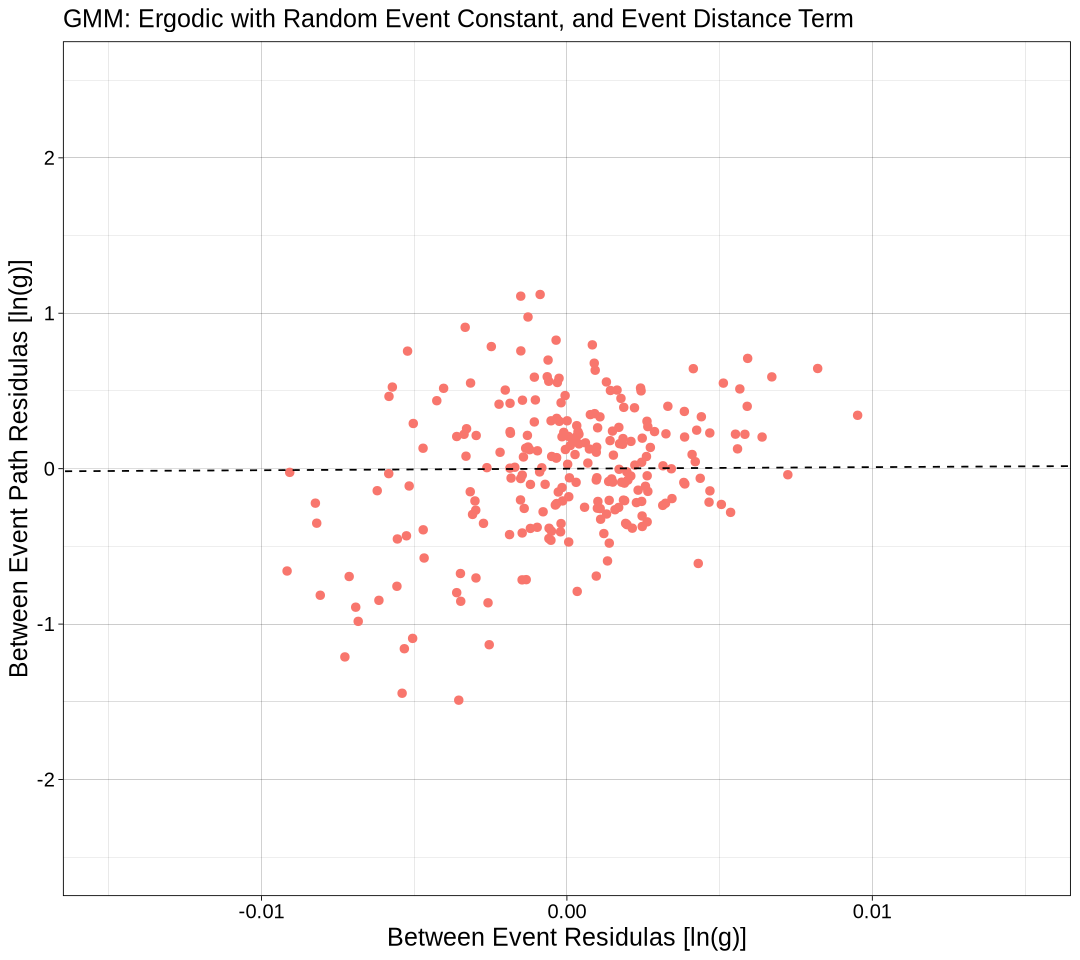

In [22]:
title_name <- 'GMM: Ergodic with Random Event Constant, and Event Distance Term'
pl_gmm_erg_rnd_ceq_req_dB_dBP <- ggplot(data=df_gmm_reff_eq, aes(x=gmm_erg_rnd_ceq_req_dBP, y=gmm_erg_rnd_ceq_req_dB)) +
                                    geom_point(aes(color=as.factor(1)), size=2) +
                                    stat_summary_bin(aes(linewidth=as.factor(1)), fun.data=mean.2th.98th, breaks=seq(3.,8.,by=0.5)) +
                                    geom_abline(intercept=0, slope=1,linetype="dashed") +
                                    labs(x='Between Event Residulas [ln(g)]', y='Between Event Path Residulas [ln(g)]', 
                                         linetype='Model', linewidth='Mean Error:',
                                          title=title_name) +
                                    xlim(-0.015, 0.015) + ylim(-2.5, 2.5) +
                                    theme(plot.title=element_text(size=size_title),  axis.title=element_text(size=size_title), 
                                          axis.text.y=element_text(size=size_text),  axis.text.x=element_text(size=size_text),
                                          legend.title=element_text(size=size_text), legend.text=element_text(size=size_text)) +
                                    theme(legend.position = "none")

options(repr.plot.width=9, repr.plot.height=8)
pl_gmm_erg_rnd_ceq_req_dB_dBP

### Difference

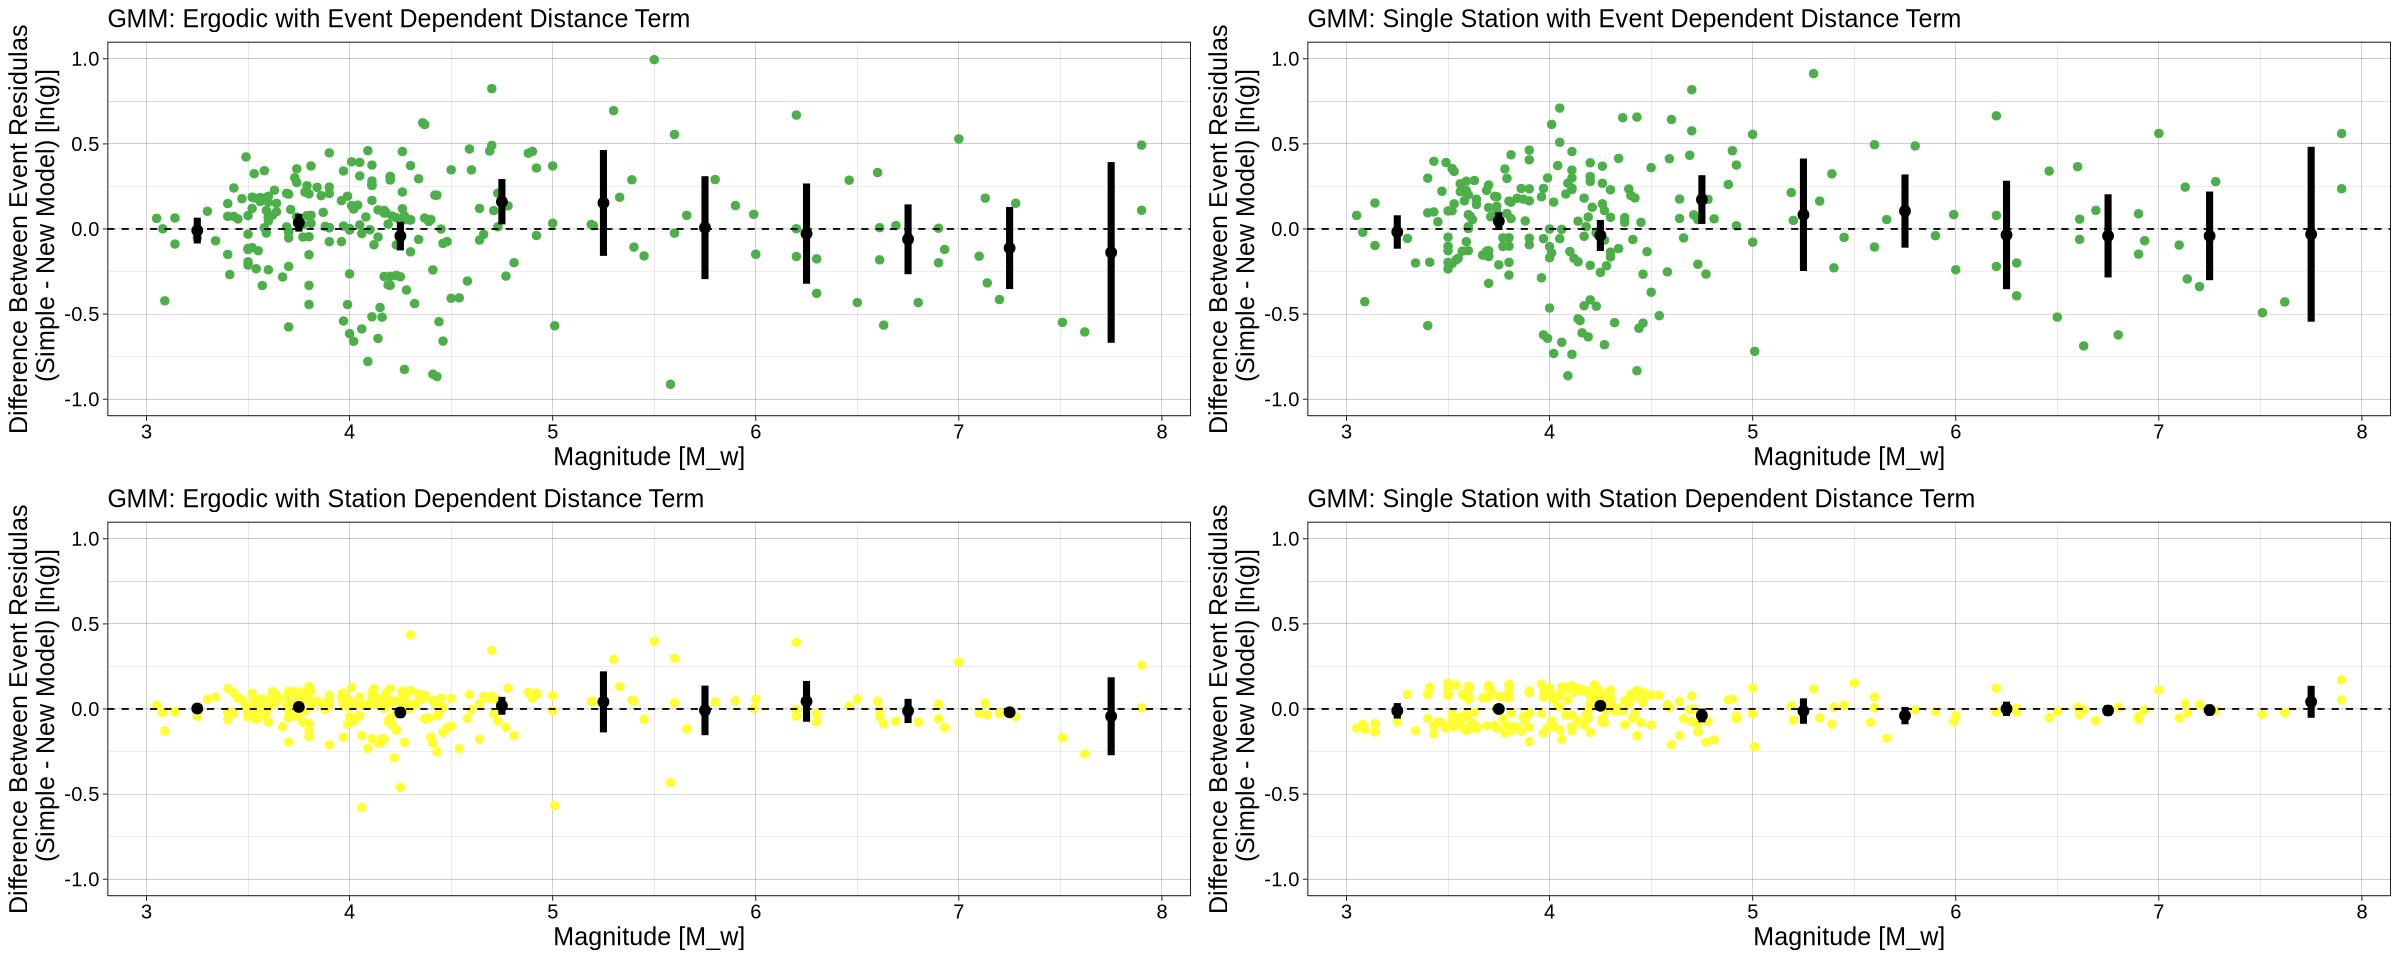

In [23]:
#Event Dependent Distance Term
title_name <- 'GMM: Ergodic with Event Dependent Distance Term'
pl_gmm_erg_req_diff_dB_mag <- ggplot(data=df_gmm_reff_eq, aes(x=magnitude, y=gmm_erg_rnd_ceq_dB-gmm_erg_rnd_ceq_req_dB)) +
                                    geom_point(aes(color=as.factor(1)), size=2) +
                                    stat_summary_bin(aes(linewidth=as.factor(1)), fun.data=mean.2th.98th, breaks=seq(3.,8.,by=0.5)) +
                                    geom_hline(yintercept=0,linetype="dashed") +
                                    scale_color_manual(values=c(color_dBP)) +
                                    labs(x='Magnitude [M_w]', y='Difference Between Event Residulas\n (Simple - New Model) [ln(g)]', 
                                         linetype='Model', linewidth='Mean Error:',
                                         title=title_name) +
                                    ylim(-1, 1) +
                                    theme(plot.title=element_text(size=size_title),  axis.title=element_text(size=size_title), 
                                          axis.text.y=element_text(size=size_text),  axis.text.x=element_text(size=size_text),
                                          legend.title=element_text(size=size_text), legend.text=element_text(size=size_text)) +
                                    theme(legend.position = "none")

title_name <- 'GMM: Single Station with Event Dependent Distance Term'
pl_gmm_ss_req_diff_dB_mag <- ggplot(data=df_gmm_reff_eq, aes(x=magnitude, y=gmm_ss_rnd_ceq_cst_dB-gmm_ss_rnd_ceq_cst_req_dB)) +
                                    geom_point(aes(color=as.factor(1)), size=2) +
                                    stat_summary_bin(aes(linewidth=as.factor(1)), fun.data=mean.2th.98th, breaks=seq(3.,8.,by=0.5)) +
                                    geom_hline(yintercept=0,linetype="dashed") +
                                    scale_color_manual(values=c(color_dBP)) +
                                    labs(x='Magnitude [M_w]', y='Difference Between Event Residulas\n (Simple - New Model) [ln(g)]', 
                                         linetype='Model', linewidth='Mean Error:',
                                         title=title_name) +
                                    ylim(-1, 1) +
                                    theme(plot.title=element_text(size=size_title),  axis.title=element_text(size=size_title), 
                                          axis.text.y=element_text(size=size_text),  axis.text.x=element_text(size=size_text),
                                          legend.title=element_text(size=size_text), legend.text=element_text(size=size_text)) +
                                    theme(legend.position = "none")

#Station Dependent Distance Term
title_name <- 'GMM: Ergodic with Station Dependent Distance Term'
pl_gmm_erg_rst_diff_dB_mag <- ggplot(data=df_gmm_reff_eq, aes(x=magnitude, y=gmm_erg_rnd_ceq_dB-gmm_erg_rnd_ceq_rst_dB)) +
                                    geom_point(aes(color=as.factor(1)), size=2) +
                                    stat_summary_bin(aes(linewidth=as.factor(1)), fun.data=mean.2th.98th, breaks=seq(3.,8.,by=0.5)) +
                                    geom_hline(yintercept=0,linetype="dashed") +
                                    scale_color_manual(values=c(color_dSP2SP)) +
                                    labs(x='Magnitude [M_w]', y='Difference Between Event Residulas\n (Simple - New Model) [ln(g)]', 
                                         linetype='Model', linewidth='Mean Error:',
                                         title=title_name) +
                                    ylim(-1, 1) +
                                    theme(plot.title=element_text(size=size_title),  axis.title=element_text(size=size_title), 
                                          axis.text.y=element_text(size=size_text),  axis.text.x=element_text(size=size_text),
                                          legend.title=element_text(size=size_text), legend.text=element_text(size=size_text)) +
                                    theme(legend.position = "none")

title_name <- 'GMM: Single Station with Station Dependent Distance Term'
pl_gmm_ss_rst_diff_dB_mag <- ggplot(data=df_gmm_reff_eq, aes(x=magnitude, y=gmm_ss_rnd_ceq_cst_dB-gmm_ss_rnd_ceq_cst_rst_dB)) +
                                    geom_point(aes(color=as.factor(1)), size=2) +
                                    stat_summary_bin(aes(linewidth=as.factor(1)), fun.data=mean.2th.98th, breaks=seq(3.,8.,by=0.5)) +
                                    geom_hline(yintercept=0,linetype="dashed") +
                                    scale_color_manual(values=c(color_dSP2SP)) +
                                    labs(x='Magnitude [M_w]', y='Difference Between Event Residulas\n (Simple - New Model) [ln(g)]', 
                                         linetype='Model', linewidth='Mean Error:',
                                         title=title_name) +
                                    ylim(-1, 1) +
                                    theme(plot.title=element_text(size=size_title),  axis.title=element_text(size=size_title), 
                                          axis.text.y=element_text(size=size_text),  axis.text.x=element_text(size=size_text),
                                          legend.title=element_text(size=size_text), legend.text=element_text(size=size_text)) +
                                    theme(legend.position = "none")


options(repr.plot.width=20, repr.plot.height=8)
ggarrange(ggarrange(pl_gmm_erg_req_diff_dB_mag,  pl_gmm_ss_req_diff_dB_mag, ncol = 2, nrow = 1),
          ggarrange(pl_gmm_erg_rst_diff_dB_mag,  pl_gmm_ss_rst_diff_dB_mag, ncol = 2, nrow = 1),
          ncol = 1, nrow = 2)

### Effect of Distant Records on Withinevent Distribution at Short Distances

In [24]:
calc_sortdist_res <- function(df_res, group_col='event_id', res_col='dW', dist_col='rrup', 
                              dist_shortthres=20, dist_reffun =function(x) quantile(x, probs=.75)){

    #suppress warnings
    options(warn=-1)
    
    #dataframe for group info
    df <- data.frame(grp=unique(df_res[,group_col]))

    #iterate over groups
    for(j in seq(nrow(df))){
        #group id
        grp_id <- df[j,group_col]
        #subset residuals to group of interest
        df_res_g <- df_res[df_res[,group_col]==grp_id, ]
        
        #mean residual within threshold
        meanres <- colMeans( df_res_g[ df_res_g[,dist_col]<=dist_shortthres,res_col], na.rm=TRUE)
        #reference distance metric
        dist_ref <- dist_reffun( as.array(t(df_res_g[,dist_col])) )
                
        #store computed values
        df[j,'meanres_sdist'] <- meanres
        df[j,'refdist']      <- dist_ref

    }
    
    options(warn=0)
    return(df)    
}

Warning message:
“Using linewidth for a discrete variable is not advised.”
Warning message:
“Removed 1 rows containing non-finite values (`stat_summary_bin()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”
Warning message:
“Using linewidth for a discrete variable is not advised.”
Warning message:
“Removed 1 rows containing non-finite values (`stat_summary_bin()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”
Warning message:
“Using linewidth for a discrete variable is not advised.”
Warning message:
“Removed 1 rows containing non-finite values (`stat_summary_bin()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”
Warning message:
“Using linewidth for a discrete variable is not advised.”
Warning message:
“Removed 1 rows containing non-finite values (`stat_summary_bin()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”
Warning message:
“Using linewidth for a 

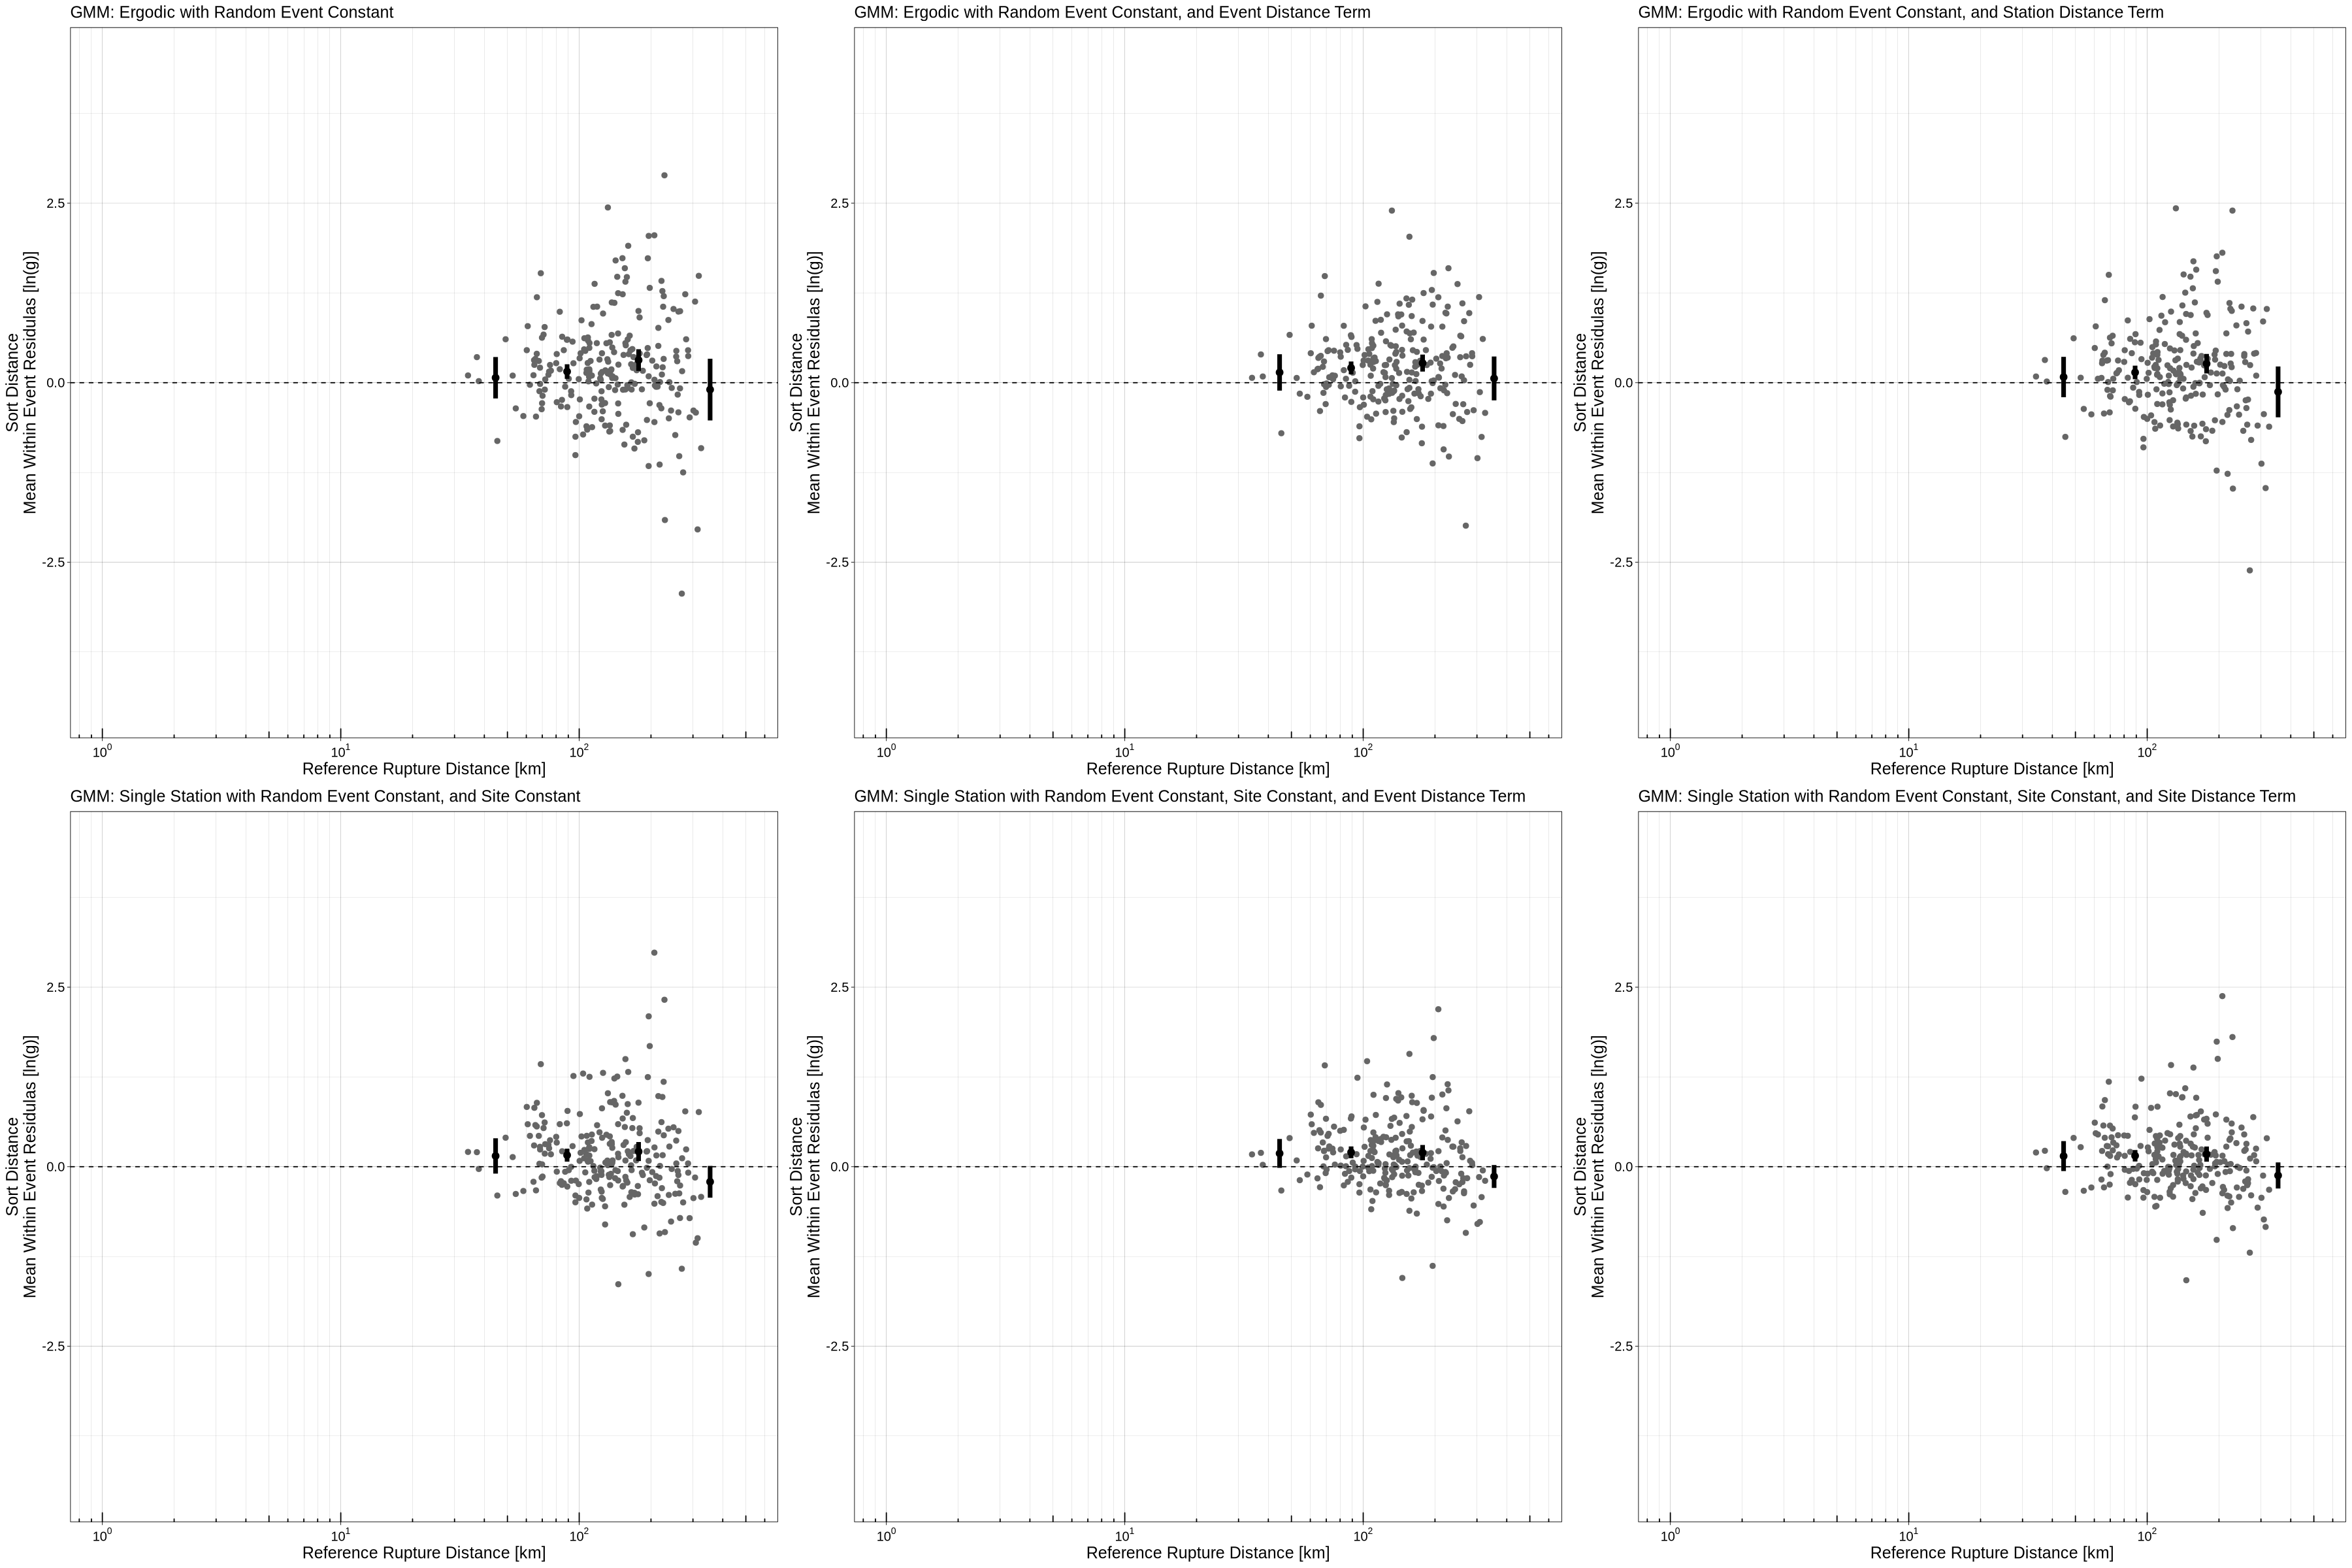

In [25]:
# Ergodic Models
title_name <- 'GMM: Ergodic with Random Event Constant'
pl_gmm_erg_rnd_ceq_sdist <- ggplot(data=calc_sortdist_res(df_gmm_res, res_col='gmm_erg_rnd_ceq_dW'), aes(x=refdist, y=meanres_sdist)) +
                                        geom_point(aes(color=as.factor(1)), size=2) +
                                        stat_summary_bin(aes(linewidth=as.factor(1)), fun.data=mean.2th.98th, breaks=logspace(log10(1),log10(500),10)) +
                                        geom_hline(yintercept=0,linetype="dashed") +
                                        scale_color_manual(values=c(color_dW)) +
                                        scale_x_log10(breaks=breaks_log,  minor_breaks=breaks_log_minor,
                                                      labels=trans_format("log10", math_format(10^.x)), 
                                                      limits=c(1, 500)) +
                                        annotation_logticks(sides="b") +
                                        labs(x='Reference Rupture Distance [km]', y='Sort Distance\nMean Within Event Residulas [ln(g)]', 
                                             linetype='Model', linewidth='Mean Error:', 
                                             title=title_name) +
                                        ylim(-4.5, 4.5) +
                                        theme(plot.title=element_text(size=size_title),  axis.title=element_text(size=size_title), 
                                              axis.text.y=element_text(size=size_text),  axis.text.x=element_text(size=size_text),
                                              legend.title=element_text(size=size_text), legend.text=element_text(size=size_text)) +
                                        theme(legend.position = "none")

title_name <- 'GMM: Ergodic with Random Event Constant, and Event Distance Term'
pl_gmm_erg_rnd_ceq_req_sdist <- ggplot(data=calc_sortdist_res(df_gmm_res, res_col='gmm_erg_rnd_ceq_req_dW'), aes(x=refdist, y=meanres_sdist)) +
                                        geom_point(aes(color=as.factor(1)), size=2) +
                                        stat_summary_bin(aes(linewidth=as.factor(1)), fun.data=mean.2th.98th, breaks=logspace(log10(1),log10(500),10)) +
                                        geom_hline(yintercept=0,linetype="dashed") +
                                        scale_color_manual(values=c(color_dW)) +
                                        scale_x_log10(breaks=breaks_log,  minor_breaks=breaks_log_minor,
                                                      labels=trans_format("log10", math_format(10^.x)), 
                                                      limits=c(1, 500)) +
                                        annotation_logticks(sides="b") +
                                        labs(x='Reference Rupture Distance [km]', y='Sort Distance\nMean Within Event Residulas [ln(g)]', 
                                             linetype='Model', linewidth='Mean Error:', 
                                             title=title_name) +
                                        ylim(-4.5, 4.5) +
                                        theme(plot.title=element_text(size=size_title),  axis.title=element_text(size=size_title), 
                                              axis.text.y=element_text(size=size_text),  axis.text.x=element_text(size=size_text),
                                              legend.title=element_text(size=size_text), legend.text=element_text(size=size_text)) +
                                        theme(legend.position = "none")

title_name <- 'GMM: Ergodic with Random Event Constant, and Station Distance Term'
pl_gmm_erg_rnd_ceq_rst_sdist <- ggplot(data=calc_sortdist_res(df_gmm_res, res_col='gmm_erg_rnd_ceq_rst_dW'), aes(x=refdist, y=meanres_sdist)) +
                                        geom_point(aes(color=as.factor(1)), size=2) +
                                        stat_summary_bin(aes(linewidth=as.factor(1)), fun.data=mean.2th.98th, breaks=logspace(log10(1),log10(500),10)) +
                                        geom_hline(yintercept=0,linetype="dashed") +
                                        scale_color_manual(values=c(color_dW)) +
                                        scale_x_log10(breaks=breaks_log,  minor_breaks=breaks_log_minor,
                                                      labels=trans_format("log10", math_format(10^.x)), 
                                                      limits=c(1, 500)) +
                                        annotation_logticks(sides="b") +
                                        labs(x='Reference Rupture Distance [km]', y='Sort Distance\nMean Within Event Residulas [ln(g)]', 
                                             linetype='Model', linewidth='Mean Error:', 
                                             title=title_name) +
                                        ylim(-4.5, 4.5) +
                                        theme(plot.title=element_text(size=size_title),  axis.title=element_text(size=size_title), 
                                              axis.text.y=element_text(size=size_text),  axis.text.x=element_text(size=size_text),
                                              legend.title=element_text(size=size_text), legend.text=element_text(size=size_text)) +
                                        theme(legend.position = "none")

# Single Station Models
title_name <- 'GMM: Single Station with Random Event Constant, and Site Constant'
pl_gmm_ss_rnd_ceq_cst_sdist <- ggplot(data=calc_sortdist_res(df_gmm_res, res_col='gmm_ss_rnd_ceq_cst_dW'), aes(x=refdist, y=meanres_sdist)) +
                                        geom_point(aes(color=as.factor(1)), size=2) +
                                        stat_summary_bin(aes(linewidth=as.factor(1)), fun.data=mean.2th.98th, breaks=logspace(log10(1),log10(500),10)) +
                                        geom_hline(yintercept=0,linetype="dashed") +
                                        scale_color_manual(values=c(color_dW)) +
                                        scale_x_log10(breaks=breaks_log,  minor_breaks=breaks_log_minor,
                                                      labels=trans_format("log10", math_format(10^.x)), 
                                                      limits=c(1, 500)) +
                                        annotation_logticks(sides="b") +
                                        labs(x='Reference Rupture Distance [km]', y='Sort Distance\nMean Within Event Residulas [ln(g)]', 
                                             linetype='Model', linewidth='Mean Error:', 
                                             title=title_name) +
                                        ylim(-4.5, 4.5) +
                                        theme(plot.title=element_text(size=size_title),  axis.title=element_text(size=size_title), 
                                              axis.text.y=element_text(size=size_text),  axis.text.x=element_text(size=size_text),
                                              legend.title=element_text(size=size_text), legend.text=element_text(size=size_text)) +
                                        theme(legend.position = "none")

title_name <- 'GMM: Single Station with Random Event Constant, Site Constant, and Event Distance Term'
pl_gmm_ss_rnd_ceq_cst_req_sdist <- ggplot(data=calc_sortdist_res(df_gmm_res, res_col='gmm_ss_rnd_ceq_cst_req_dW'), aes(x=refdist, y=meanres_sdist)) +
                                        geom_point(aes(color=as.factor(1)), size=2) +
                                        stat_summary_bin(aes(linewidth=as.factor(1)), fun.data=mean.2th.98th, breaks=logspace(log10(1),log10(500),10)) +
                                        geom_hline(yintercept=0,linetype="dashed") +
                                        scale_color_manual(values=c(color_dW)) +
                                        scale_x_log10(breaks=breaks_log,  minor_breaks=breaks_log_minor,
                                                      labels=trans_format("log10", math_format(10^.x)), 
                                                      limits=c(1, 500)) +
                                        annotation_logticks(sides="b") +
                                        labs(x='Reference Rupture Distance [km]', y='Sort Distance\nMean Within Event Residulas [ln(g)]', 
                                             linetype='Model', linewidth='Mean Error:', 
                                             title=title_name) +
                                        ylim(-4.5, 4.5) +
                                        theme(plot.title=element_text(size=size_title),  axis.title=element_text(size=size_title), 
                                              axis.text.y=element_text(size=size_text),  axis.text.x=element_text(size=size_text),
                                              legend.title=element_text(size=size_text), legend.text=element_text(size=size_text)) +
                                        theme(legend.position = "none")

title_name <- 'GMM: Single Station with Random Event Constant, Site Constant, and Site Distance Term'
pl_gmm_ss_rnd_ceq_cst_rst_sdist <- ggplot(data=calc_sortdist_res(df_gmm_res, res_col='gmm_ss_rnd_ceq_cst_rst_dW'), aes(x=refdist, y=meanres_sdist)) +
                                        geom_point(aes(color=as.factor(1)), size=2) +
                                        stat_summary_bin(aes(linewidth=as.factor(1)), fun.data=mean.2th.98th, breaks=logspace(log10(1),log10(500),10)) +
                                        geom_hline(yintercept=0,linetype="dashed") +
                                        scale_color_manual(values=c(color_dW)) +
                                        scale_x_log10(breaks=breaks_log,  minor_breaks=breaks_log_minor,
                                                      labels=trans_format("log10", math_format(10^.x)), 
                                                      limits=c(1, 500)) +
                                        annotation_logticks(sides="b") +
                                        labs(x='Reference Rupture Distance [km]', y='Sort Distance\nMean Within Event Residulas [ln(g)]', 
                                             linetype='Model', linewidth='Mean Error:', 
                                             title=title_name) +
                                        ylim(-4.5, 4.5) +
                                        theme(plot.title=element_text(size=size_title),  axis.title=element_text(size=size_title), 
                                              axis.text.y=element_text(size=size_text),  axis.text.x=element_text(size=size_text),
                                              legend.title=element_text(size=size_text), legend.text=element_text(size=size_text)) +
                                        theme(legend.position = "none")


options(repr.plot.width=30, repr.plot.height=20)
ggarrange(ggarrange(pl_gmm_erg_rnd_ceq_sdist,    pl_gmm_erg_rnd_ceq_req_sdist,    pl_gmm_erg_rnd_ceq_rst_sdist,    ncol=3, nrow=1),
          ggarrange(pl_gmm_ss_rnd_ceq_cst_sdist, pl_gmm_ss_rnd_ceq_cst_req_sdist, pl_gmm_ss_rnd_ceq_cst_rst_sdist, ncol=3, nrow=1),
          ncol = 1, nrow = 2)

### Spatial Distribution of Random Effects

Warning message in spTransform(xSP, CRSobj, ...):
“NULL source CRS comment, falling back to PROJ string”
Warning message in spTransform(xSP, CRSobj, ...):
“NULL target CRS comment, falling back to PROJ string”
Warning message in spTransform(xSP, CRSobj, ...):
“NULL source CRS comment, falling back to PROJ string”
Warning message in spTransform(xSP, CRSobj, ...):
“NULL target CRS comment, falling back to PROJ string”


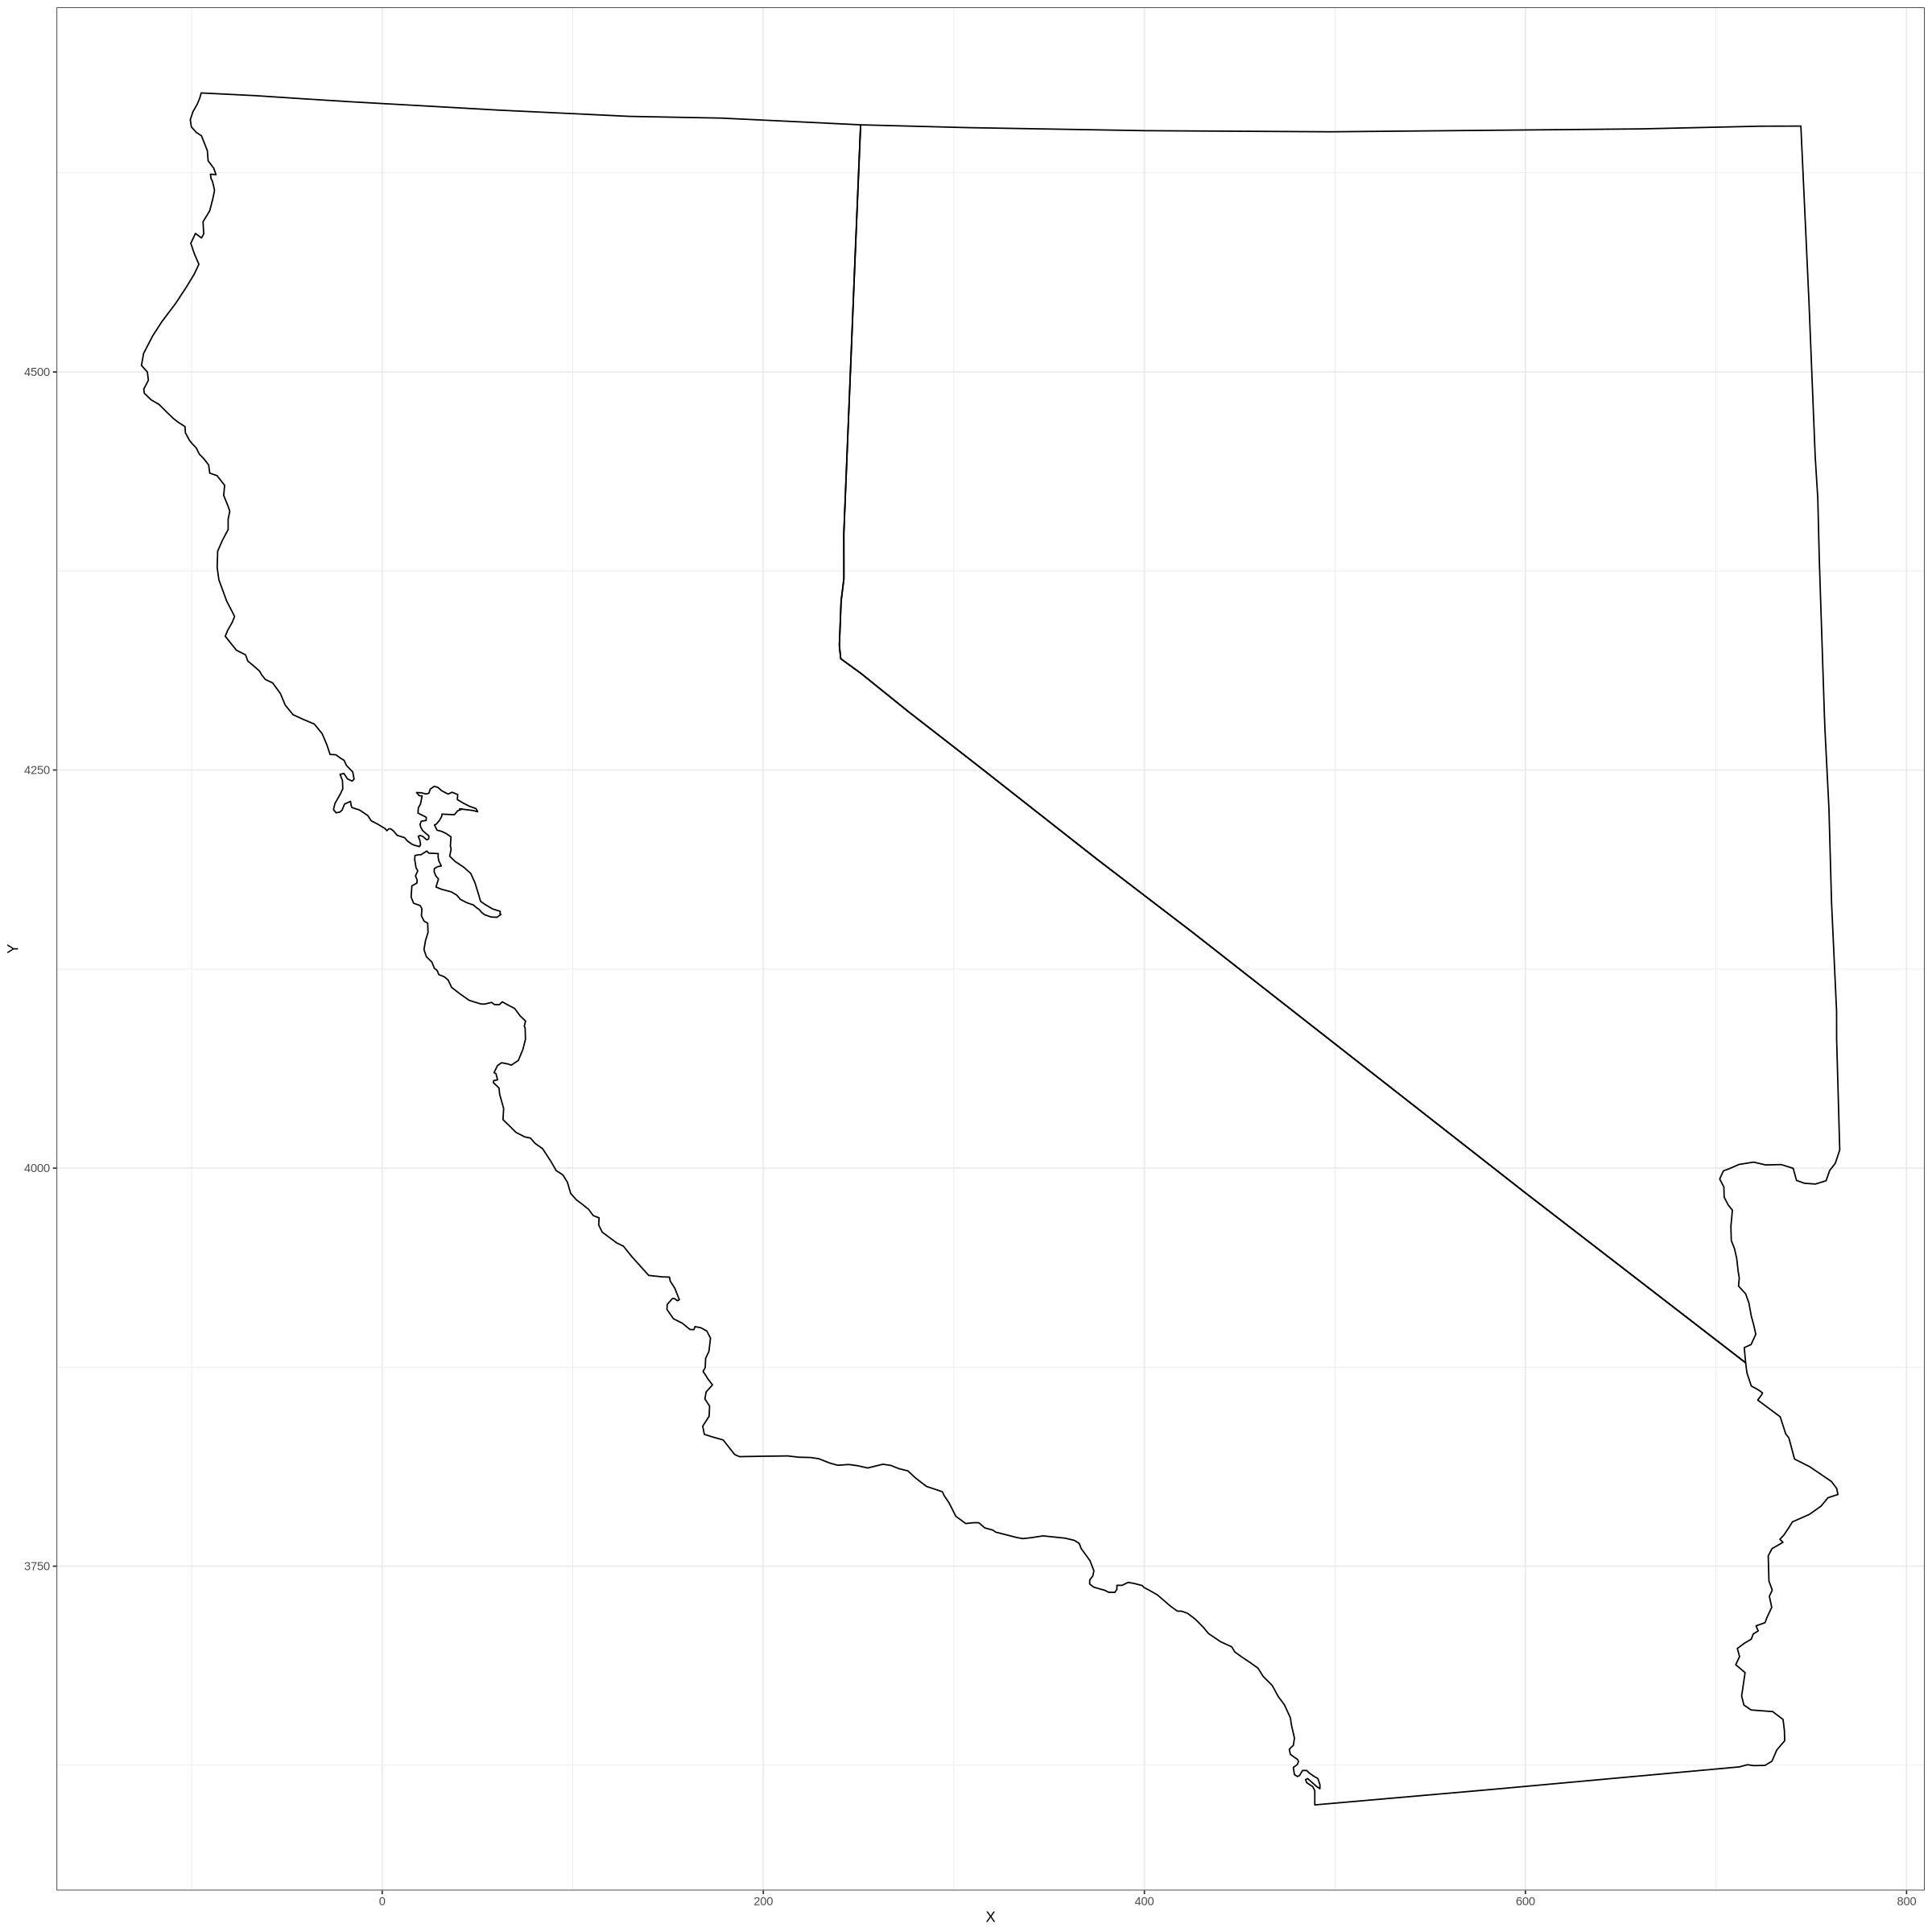

In [26]:
#UTM zone
utm_no   <- as.numeric(gsub("([0-9]+).*$", "\\1", utm_zone))
#California
map_ca     <- subset( map_data("state"), region %in% c("california"))
map_ca_utm <- LongLatToUTM(lat=map_ca$lat, lon=map_ca$long, utm_no)
map_ca[,c('X','Y')] <- map_ca_utm[,c('X','Y')]/1000
#Nevada
map_nv     <- subset( map_data("state"), region %in% c("nevada"))
map_nv_utm <- LongLatToUTM(lat=map_nv$lat, lon=map_nv$long, utm_no)
map_nv[,c('X','Y')] <- map_nv_utm[,c('X','Y')]/1000

#base map
pl_map <- ggplot() + theme_bw() +
            geom_path(data=map_ca, aes(x=X,y=Y), color='black') + 
            geom_path(data=map_nv, aes(x=X,y=Y), color='black')

options(repr.plot.width=20, repr.plot.height=20)
pl_map

## Save Results